In [1]:
# Model no 5 in paper.
import os
import numpy as np
import torch
from torch import Tensor
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.nn.functional as F
from lib.dataset_custom import KernDataset,DatasetSplit
from lib.model import ScoreModel
from lib.opt import optimize
from lib.CrossValidation import CrossValidator
from lib.config import corpora_for_classification_all_composers as default_corpora
import lib.media as media

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='1'
#os.environ['CUDA_LAUNCH_BLOCKING']='1'

checkpoint_dir = '_voices_model_500'
context = 500
corpora = tuple(default_corpora)

In [3]:
import sys
class Convnet(ScoreModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def define_graph(self, debug=False):
        self.kernel_width = 3 # window with which we scan over time
        
        self.wnotes = Parameter(Tensor(300, self.m, 1,self.kernel_width))
        self.wdurations = Parameter(Tensor(300, self.maxdur, 1, self.kernel_width))
        self.w2 = Parameter(Tensor(300, 300, 1, self.kernel_width))
        self.w3 = Parameter(Tensor(300, self.composers))
        self.bias = Parameter(Tensor(self.composers))
    
    def forward(self, x):
        e,t,_,_ = x
        batch_size = e.shape[0]
        c1 = F.relu(F.conv2d(e.view(batch_size*3, context, 6, self.m).transpose(1, 3), self.wnotes) + 
                   F.conv2d(t.view(batch_size*3, context, 6, self.maxdur).transpose(1, 3), self.wdurations))
        c2 = F.relu(F.conv2d(c1, self.w2))
        fullPool = c2.view(batch_size, 3, 300, 6, -1).mean(1).mean(2).mean(2)
        return torch.mm(fullPool, self.w3) + self.bias[None, :].expand(e.shape[0], -1)

In [4]:
validator = CrossValidator(Convnet, corpora, is_patches_model=True, patience=50, batch_size=64)

---------------------------------------------
---------------------------------------------
Fold 0
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([300, 78, 1, 3]) (70200)
wdurations torch.Size([300, 55, 1, 3]) (49500)
w2 torch.Size([300, 300, 1, 3]) (270000)
w3 torch.Size([300, 19]) (5700)
bias torch.Size([19]) (19)
Initialized graph with 395419 parameters
Initiating optimizer, 32 iterations/epoch.
acc_tr	acc_ts	iter	loss_tr	loss_ts	time	utime
3.50    5.02    0       4.25    4.25    8.40    6.12    
18.00   24.69   32      3.72    3.67    16.74   5.26    
31.50   35.98   64      2.95    3.01    15.94   5.03    
41.00   44.77   96      2.20    2.43    16.97   5.41    
53.00   53.56   128     1.82    2.02    15.89   4.62    
58.50   61.92   160     1.56    1.69    15.15   4.73    
60.00   64.02   192     1.54    1.53    

100.00  78.24   4256    0.01    2.13    14.40   4.34    
100.00  76.15   4288    0.01    2.11    15.48   4.39    
100.00  76.99   4320    0.01    2.24    15.14   4.65    
100.00  75.31   4352    0.01    2.15    15.10   4.74    
100.00  76.57   4384    0.01    2.32    14.98   4.62    
100.00  76.57   4416    0.00    2.40    14.72   3.85    
100.00  76.57   4448    0.00    2.40    15.24   4.20    
100.00  76.99   4480    0.00    2.39    15.20   4.45    
100.00  77.41   4512    0.00    2.40    14.60   4.36    
100.00  76.99   4544    0.00    2.47    15.48   4.55    
100.00  76.99   4576    0.00    2.49    13.91   4.13    
100.00  76.99   4608    0.00    2.54    13.75   3.68    
100.00  77.82   4640    0.00    2.55    13.81   3.93    
100.00  77.41   4672    0.00    2.55    14.73   3.91    
100.00  77.41   4704    0.00    2.61    14.20   4.00    
100.00  76.99   4736    0.00    2.56    14.56   3.96    
Finished
**************
Test accuracy :  0.7824267782426778


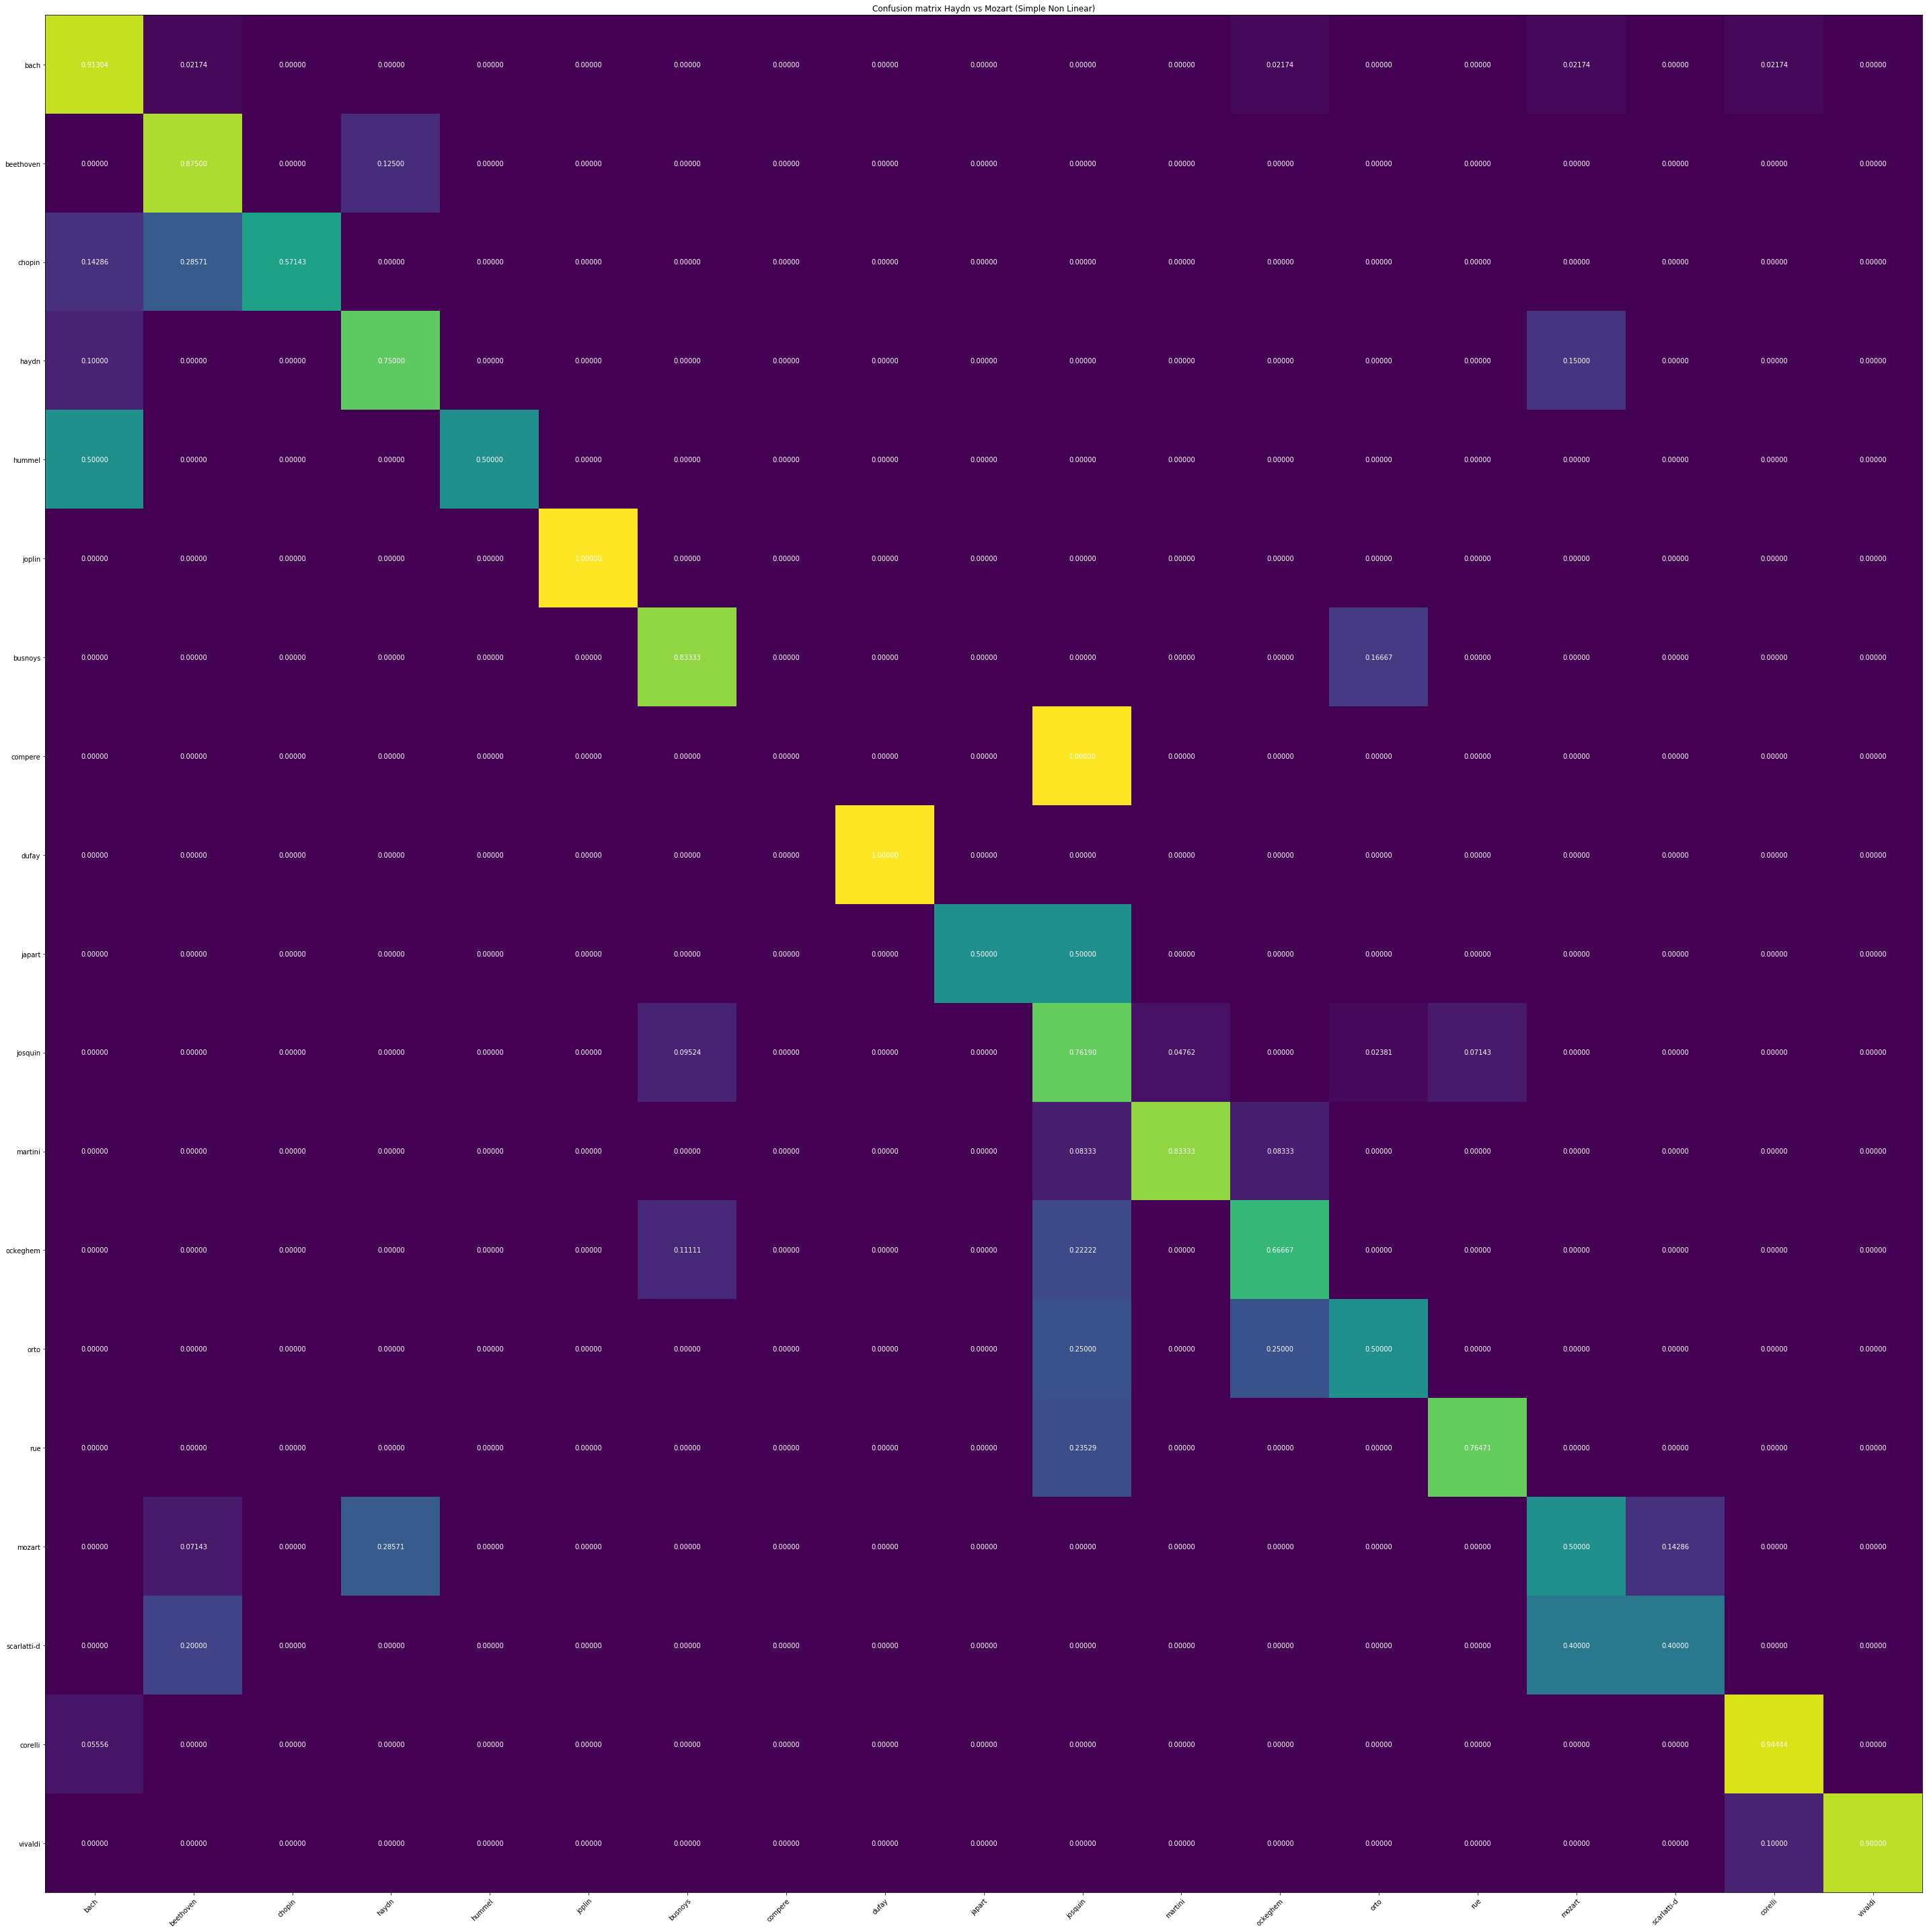

bach 42 / 46 = 0.9130434782608695
beethoven 14 / 16 = 0.875
busnoys 5 / 6 = 0.8333333333333334
chopin 4 / 7 = 0.5714285714285714
compere 0 / 2 = 0.0
corelli 17 / 18 = 0.9444444444444444
dufay 3 / 3 = 1.0
haydn 15 / 20 = 0.75
hummel 1 / 2 = 0.5
japart 1 / 2 = 0.5
joplin 4 / 4 = 1.0
josquin 32 / 42 = 0.7619047619047619
martini 10 / 12 = 0.8333333333333334
mozart 7 / 14 = 0.5
ockeghem 6 / 9 = 0.6666666666666666
orto 2 / 4 = 0.5
rue 13 / 17 = 0.7647058823529411
scarlatti-d 2 / 5 = 0.4
vivaldi 9 / 10 = 0.9
187 239 0.7824267782426778
---------------------------------------------
---------------------------------------------
Fold 1
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([300, 78, 1, 3]) (70200)
wdurations torch.Size([300, 55, 1, 3]) (49500)
w2 torch.Size([300, 300, 1, 3]) (270000)
w3 torch.Size([300, 19]) (5700)
bias 

100.00  77.82   3968    0.01    2.60    14.45   4.52    
99.50   77.41   4000    0.02    2.65    14.55   3.93    
99.50   78.24   4032    0.02    2.66    14.52   4.05    
100.00  78.66   4064    0.00    2.69    14.58   4.07    
100.00  77.82   4096    0.01    2.68    14.42   4.19    
100.00  78.24   4128    0.01    2.73    14.43   4.43    
100.00  77.82   4160    0.01    2.75    14.41   4.19    
100.00  78.24   4192    0.01    2.67    14.44   4.26    
100.00  77.41   4224    0.00    2.72    14.05   3.84    
100.00  76.15   4256    0.01    2.70    14.85   4.22    
100.00  76.57   4288    0.01    2.72    14.68   4.23    
100.00  76.99   4320    0.01    2.74    14.23   4.12    
100.00  77.82   4352    0.01    2.75    15.15   4.34    
99.50   76.99   4384    0.04    2.87    14.13   4.06    
99.50   78.24   4416    0.01    2.78    14.72   3.69    
99.50   76.99   4448    0.01    2.74    14.54   4.12    
100.00  76.99   4480    0.01    2.73    14.32   3.89    
99.50   77.82   4512    0.01   

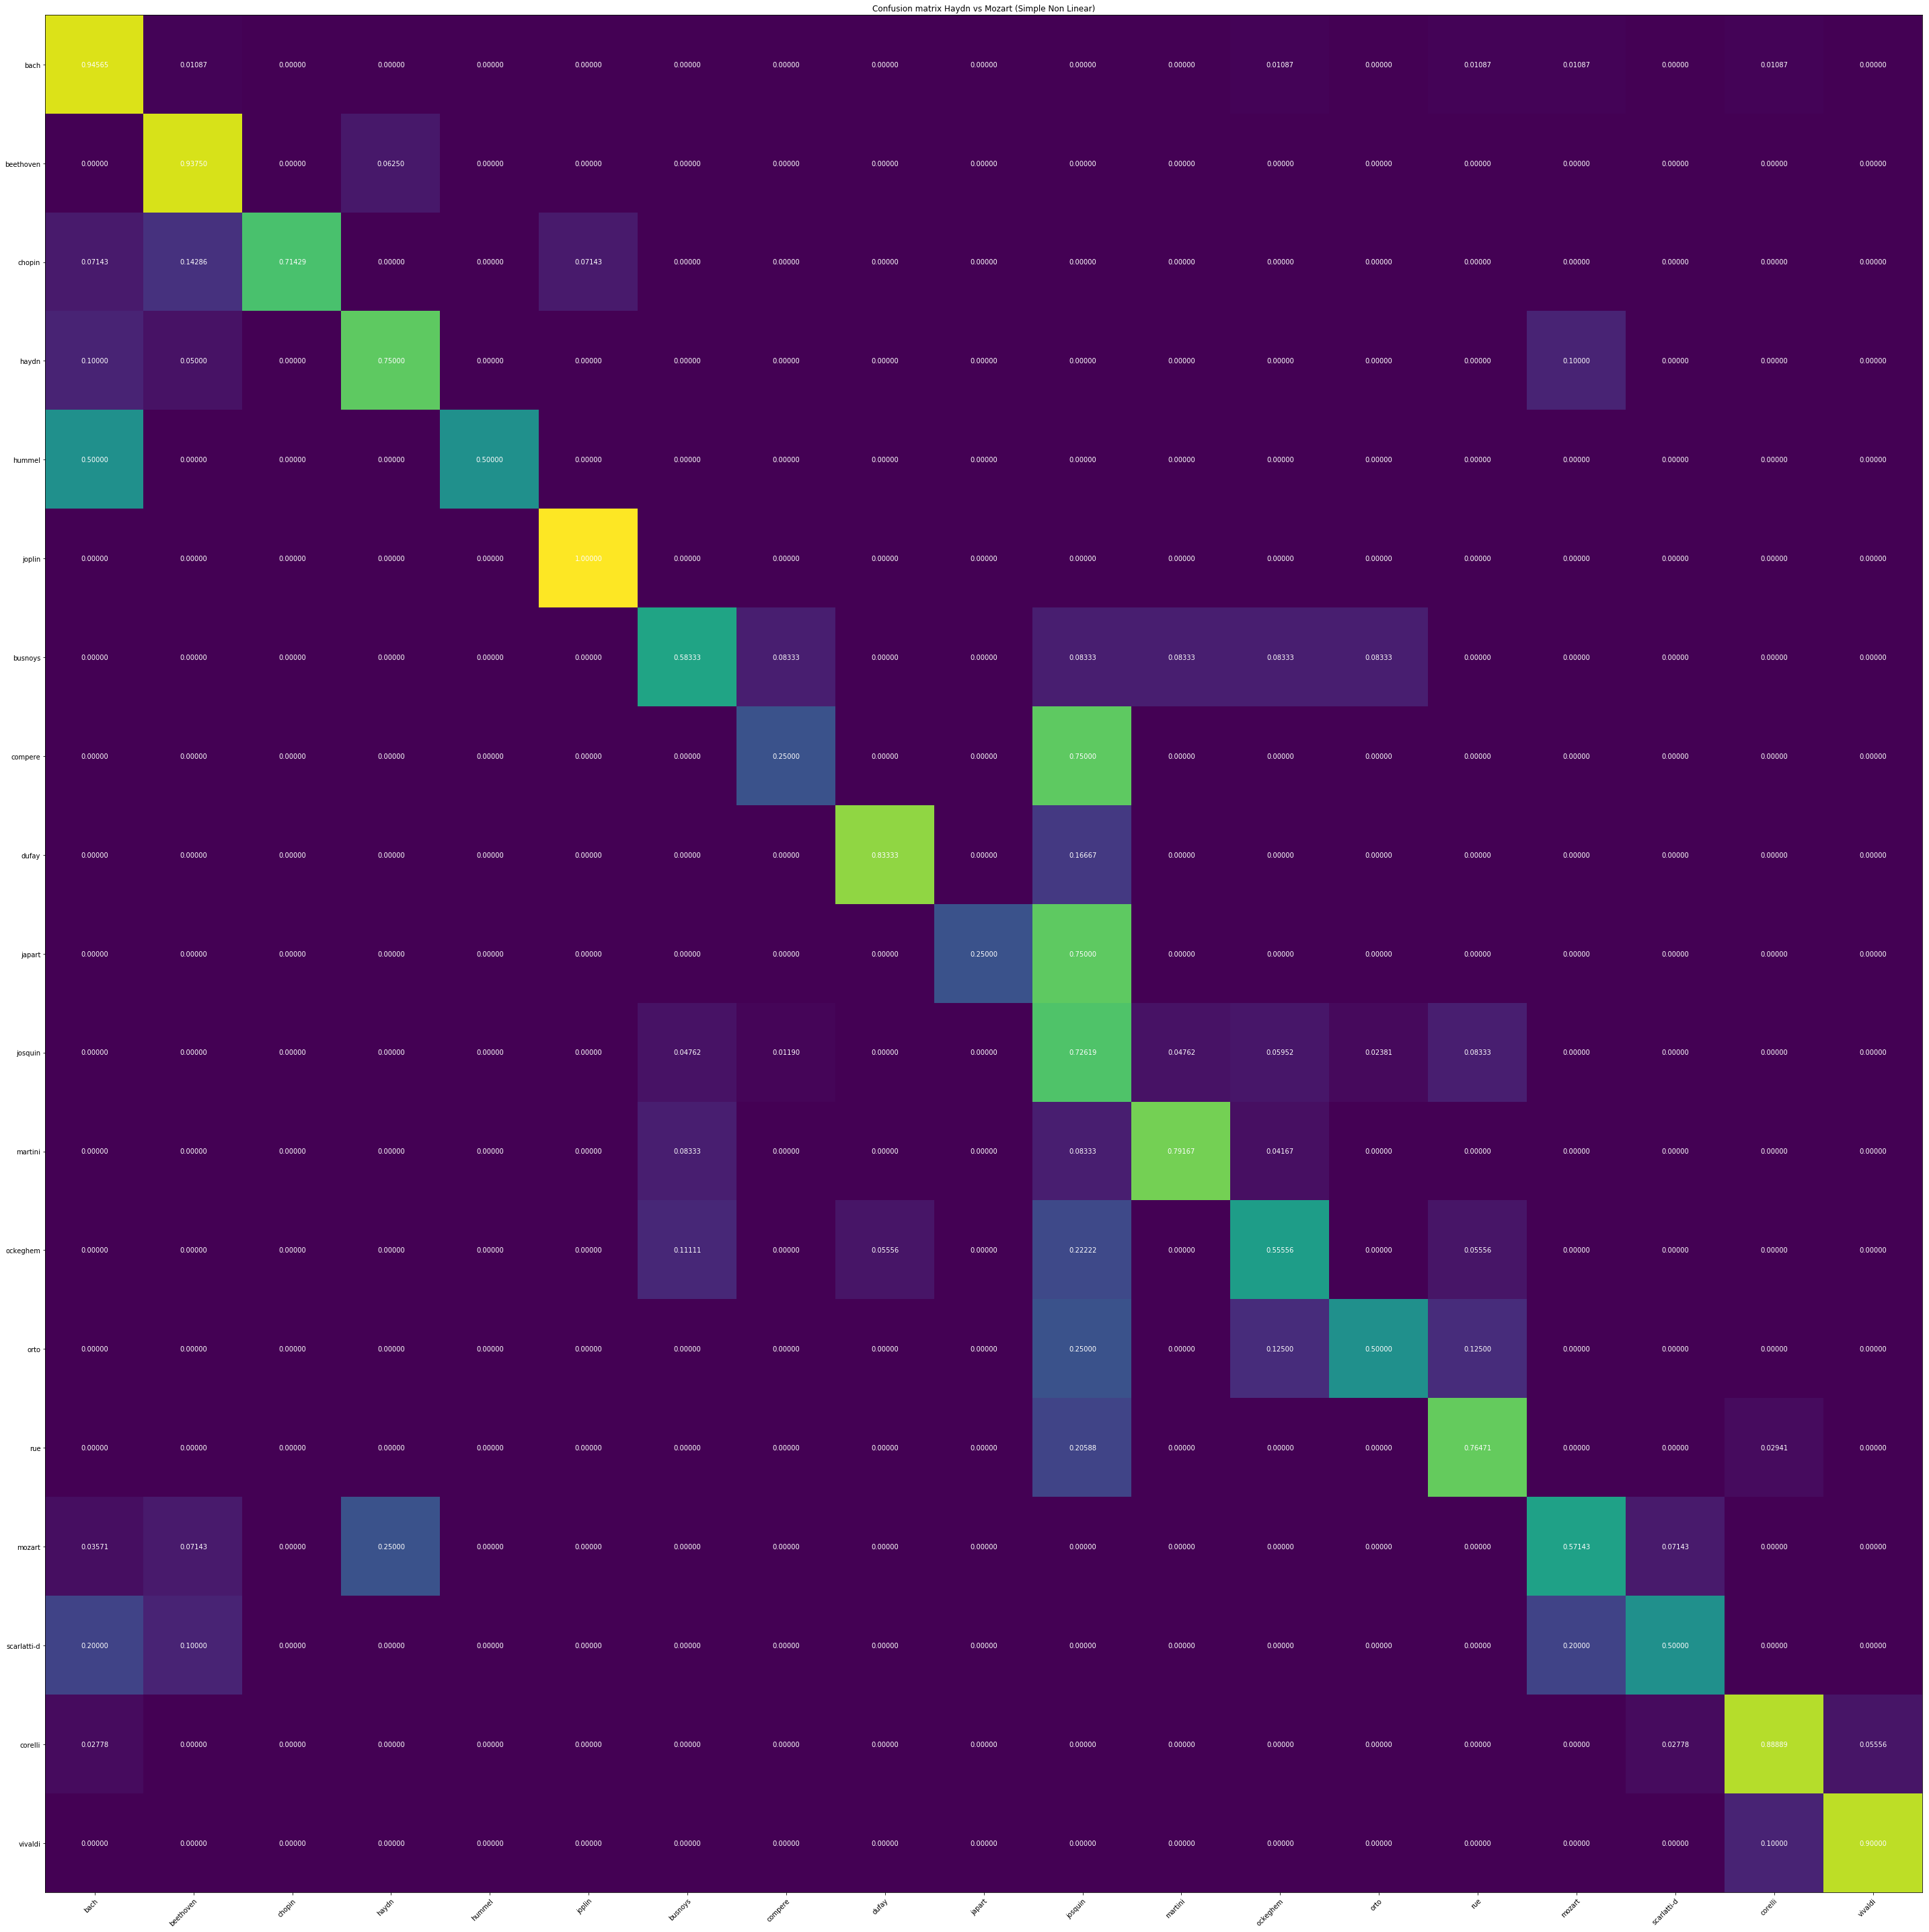

bach 45 / 46 = 0.9782608695652174
beethoven 16 / 16 = 1.0
busnoys 2 / 6 = 0.3333333333333333
chopin 6 / 7 = 0.8571428571428571
compere 1 / 2 = 0.5
corelli 15 / 18 = 0.8333333333333334
dufay 2 / 3 = 0.6666666666666666
haydn 15 / 20 = 0.75
hummel 1 / 2 = 0.5
japart 0 / 2 = 0.0
joplin 4 / 4 = 1.0
josquin 29 / 42 = 0.6904761904761905
martini 9 / 12 = 0.75
mozart 9 / 14 = 0.6428571428571429
ockeghem 4 / 9 = 0.4444444444444444
orto 2 / 4 = 0.5
rue 13 / 17 = 0.7647058823529411
scarlatti-d 3 / 5 = 0.6
vivaldi 9 / 10 = 0.9
185 239 0.7740585774058577
---------------------------------------------
---------------------------------------------
Fold 2
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([300, 78, 1, 3]) (70200)
wdurations torch.Size([300, 55, 1, 3]) (49500)
w2 torch.Size([300, 300, 1, 3]) (270000)
w3 torch.Size([300, 19])

100.00  78.66   3968    0.01    1.79    14.54   4.14    
100.00  77.41   4000    0.01    1.86    14.12   4.18    
100.00  76.57   4032    0.01    1.86    14.78   3.82    
100.00  79.08   4064    0.01    1.87    14.86   4.44    
100.00  79.08   4096    0.02    1.80    14.22   4.09    
100.00  76.99   4128    0.01    1.89    14.00   3.78    
100.00  77.82   4160    0.00    1.86    14.34   3.91    
100.00  78.24   4192    0.01    1.74    14.46   4.03    
100.00  77.41   4224    0.01    1.82    14.95   4.13    
100.00  76.15   4256    0.02    1.78    14.21   4.27    
100.00  78.66   4288    0.01    1.81    14.47   4.34    
100.00  78.66   4320    0.01    1.80    14.49   4.15    
100.00  78.66   4352    0.01    1.88    14.13   3.83    
100.00  78.66   4384    0.01    1.95    14.28   3.89    
100.00  77.82   4416    0.01    1.89    14.33   3.95    
100.00  78.24   4448    0.01    1.93    14.40   3.88    
100.00  79.92   4480    0.01    1.95    14.54   3.81    
Finished
**************
Test ac

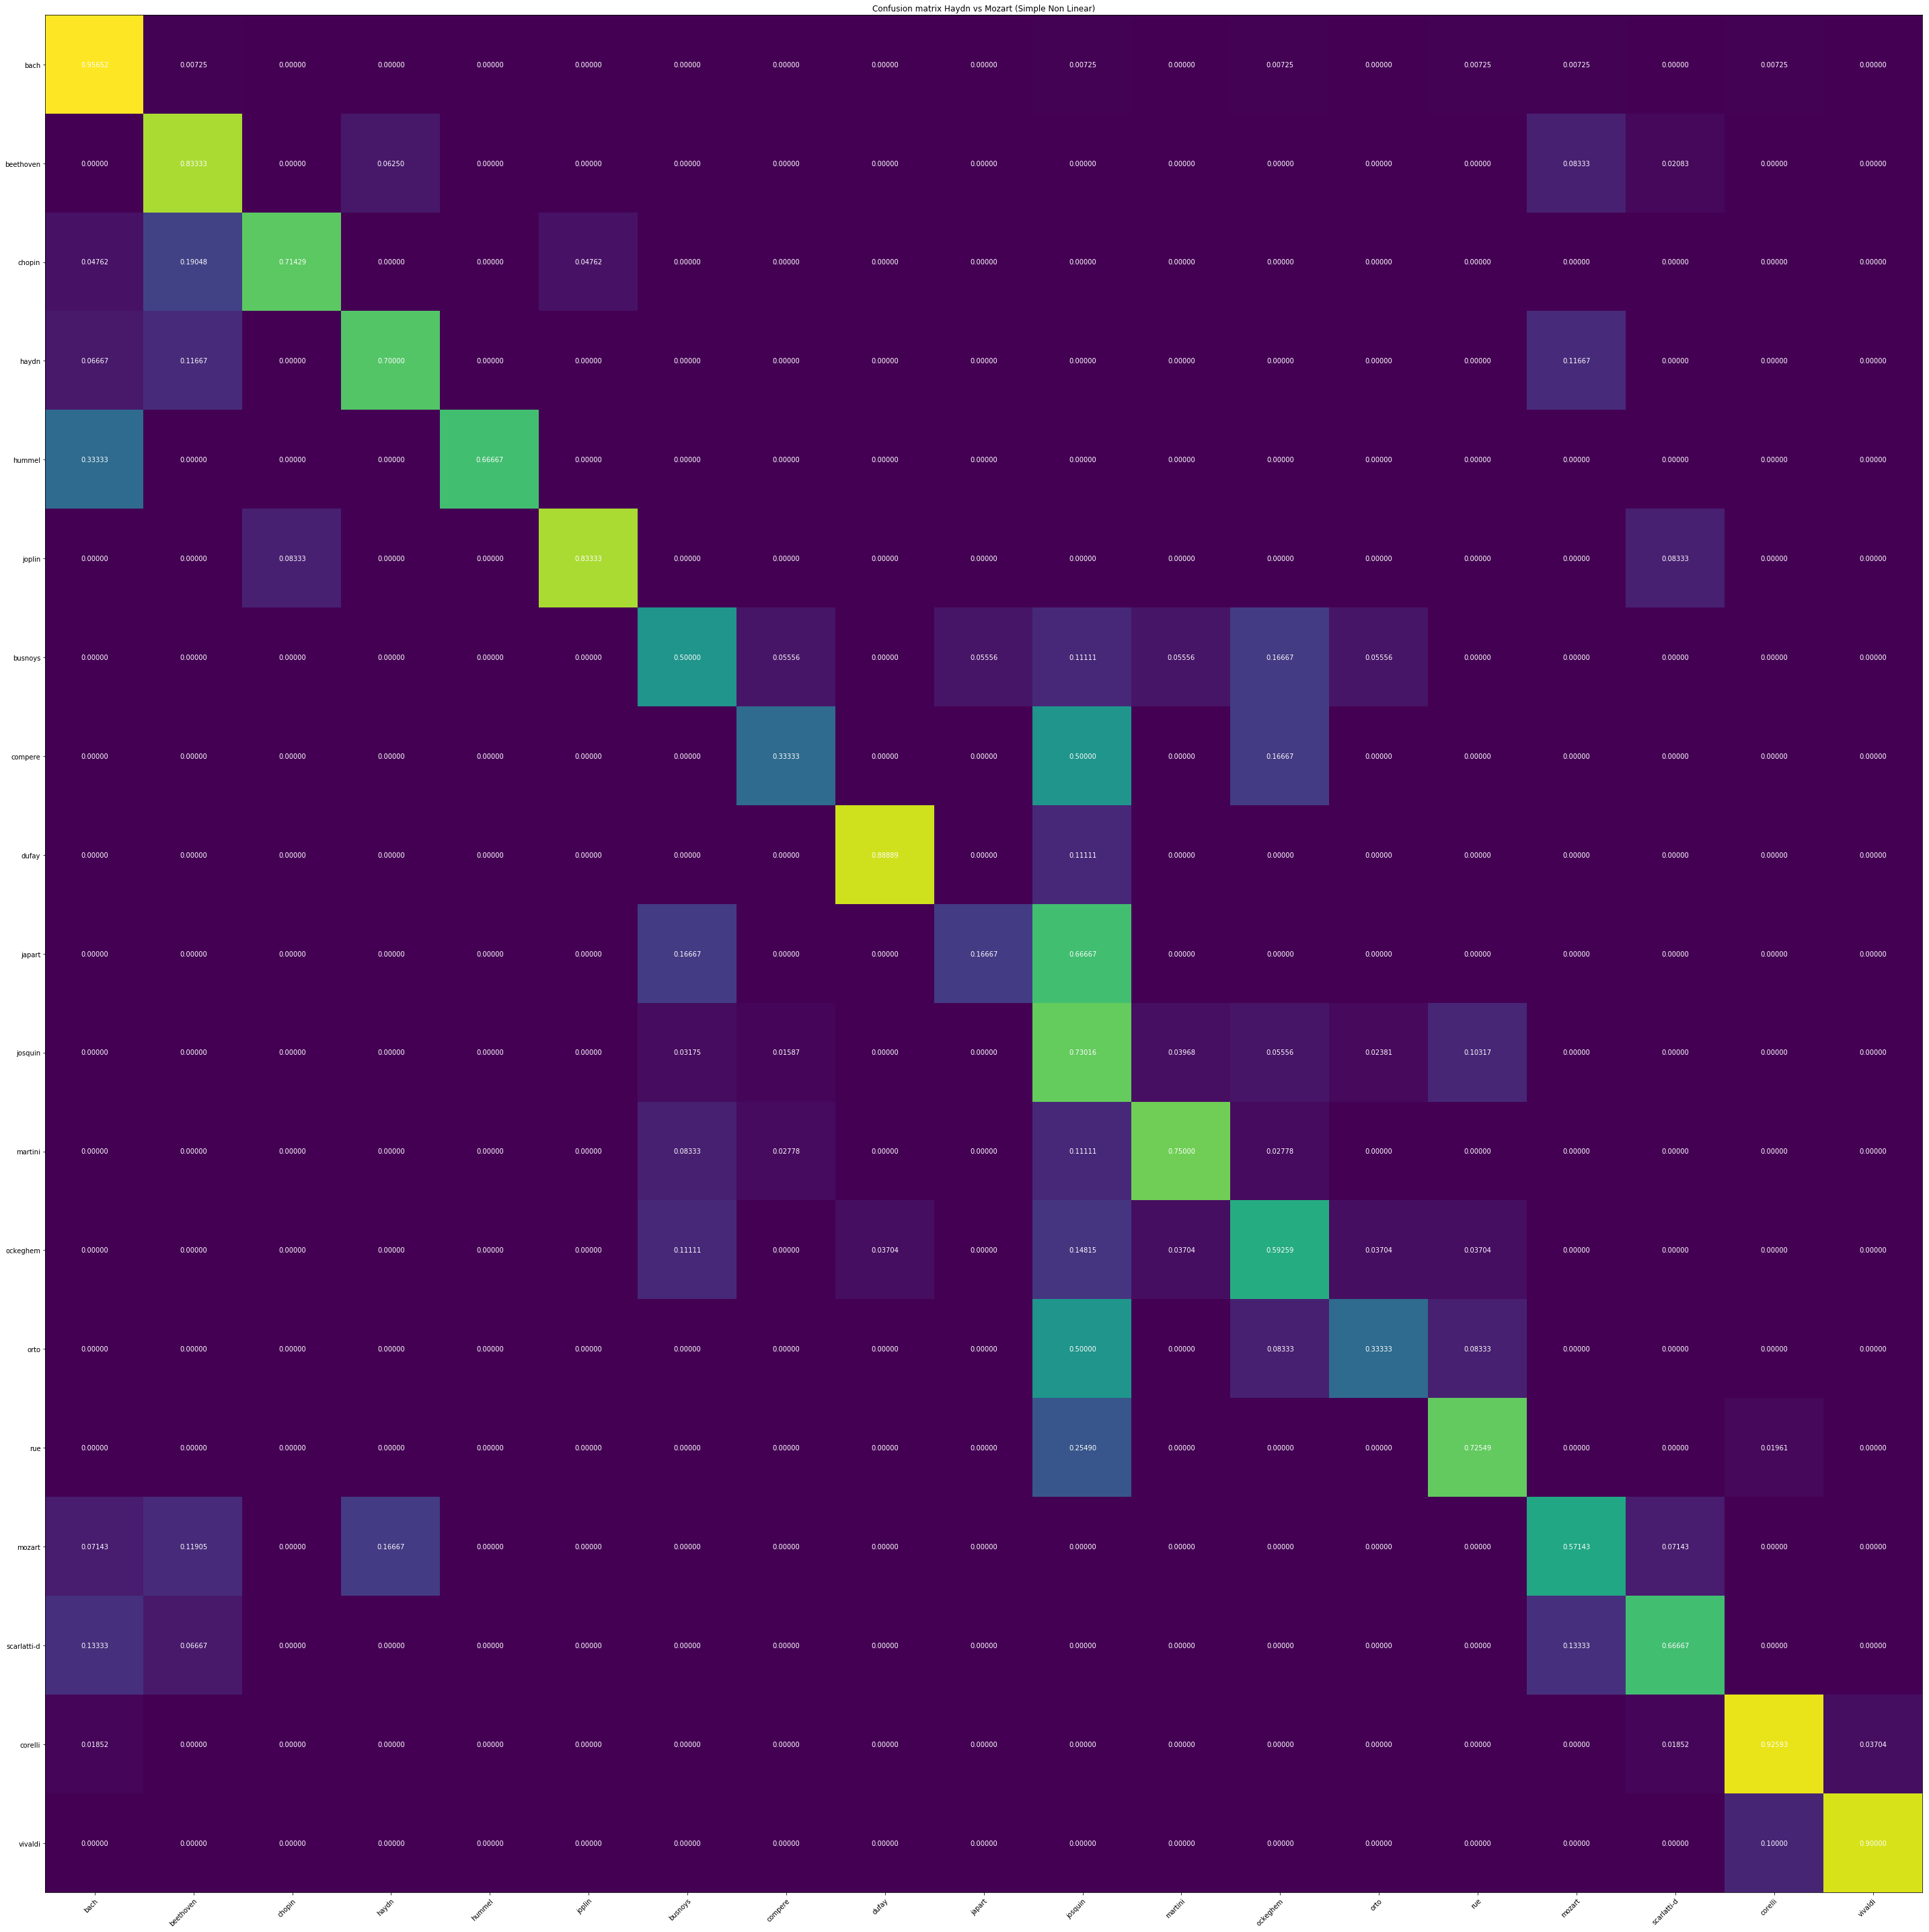

bach 45 / 46 = 0.9782608695652174
beethoven 10 / 16 = 0.625
busnoys 2 / 6 = 0.3333333333333333
chopin 5 / 7 = 0.7142857142857143
compere 1 / 2 = 0.5
corelli 18 / 18 = 1.0
dufay 3 / 3 = 1.0
haydn 12 / 20 = 0.6
hummel 2 / 2 = 1.0
japart 0 / 2 = 0.0
joplin 2 / 4 = 0.5
josquin 31 / 42 = 0.7380952380952381
martini 8 / 12 = 0.6666666666666666
mozart 8 / 14 = 0.5714285714285714
ockeghem 6 / 9 = 0.6666666666666666
orto 0 / 4 = 0.0
rue 11 / 17 = 0.6470588235294118
scarlatti-d 5 / 5 = 1.0
vivaldi 9 / 10 = 0.9
178 239 0.7447698744769874
---------------------------------------------
---------------------------------------------
Fold 3
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([300, 78, 1, 3]) (70200)
wdurations torch.Size([300, 55, 1, 3]) (49500)
w2 torch.Size([300, 300, 1, 3]) (270000)
w3 torch.Size([300, 19]) (5700)
bias to

100.00  81.59   3968    0.01    1.67    14.47   4.31    
100.00  81.17   4000    0.01    1.67    14.54   4.14    
100.00  83.26   4032    0.01    1.63    14.52   4.36    
100.00  82.85   4064    0.01    1.54    14.25   4.14    
100.00  82.43   4096    0.01    1.56    14.57   4.32    
100.00  82.85   4128    0.01    1.60    14.47   4.33    
100.00  82.01   4160    0.01    1.60    14.65   4.23    
100.00  82.01   4192    0.01    1.62    14.39   4.25    
100.00  82.01   4224    0.00    1.63    15.00   3.95    
100.00  82.01   4256    0.01    1.68    14.75   4.34    
100.00  81.59   4288    0.00    1.70    14.31   4.18    
100.00  82.43   4320    0.00    1.68    15.24   4.16    
100.00  82.01   4352    0.00    1.75    14.69   4.20    
100.00  82.43   4384    0.00    1.77    14.57   4.38    
100.00  83.26   4416    0.01    1.73    14.77   4.28    
100.00  80.75   4448    0.00    1.68    14.52   4.51    
100.00  81.17   4480    0.01    1.72    14.83   4.08    
100.00  82.01   4512    0.01   

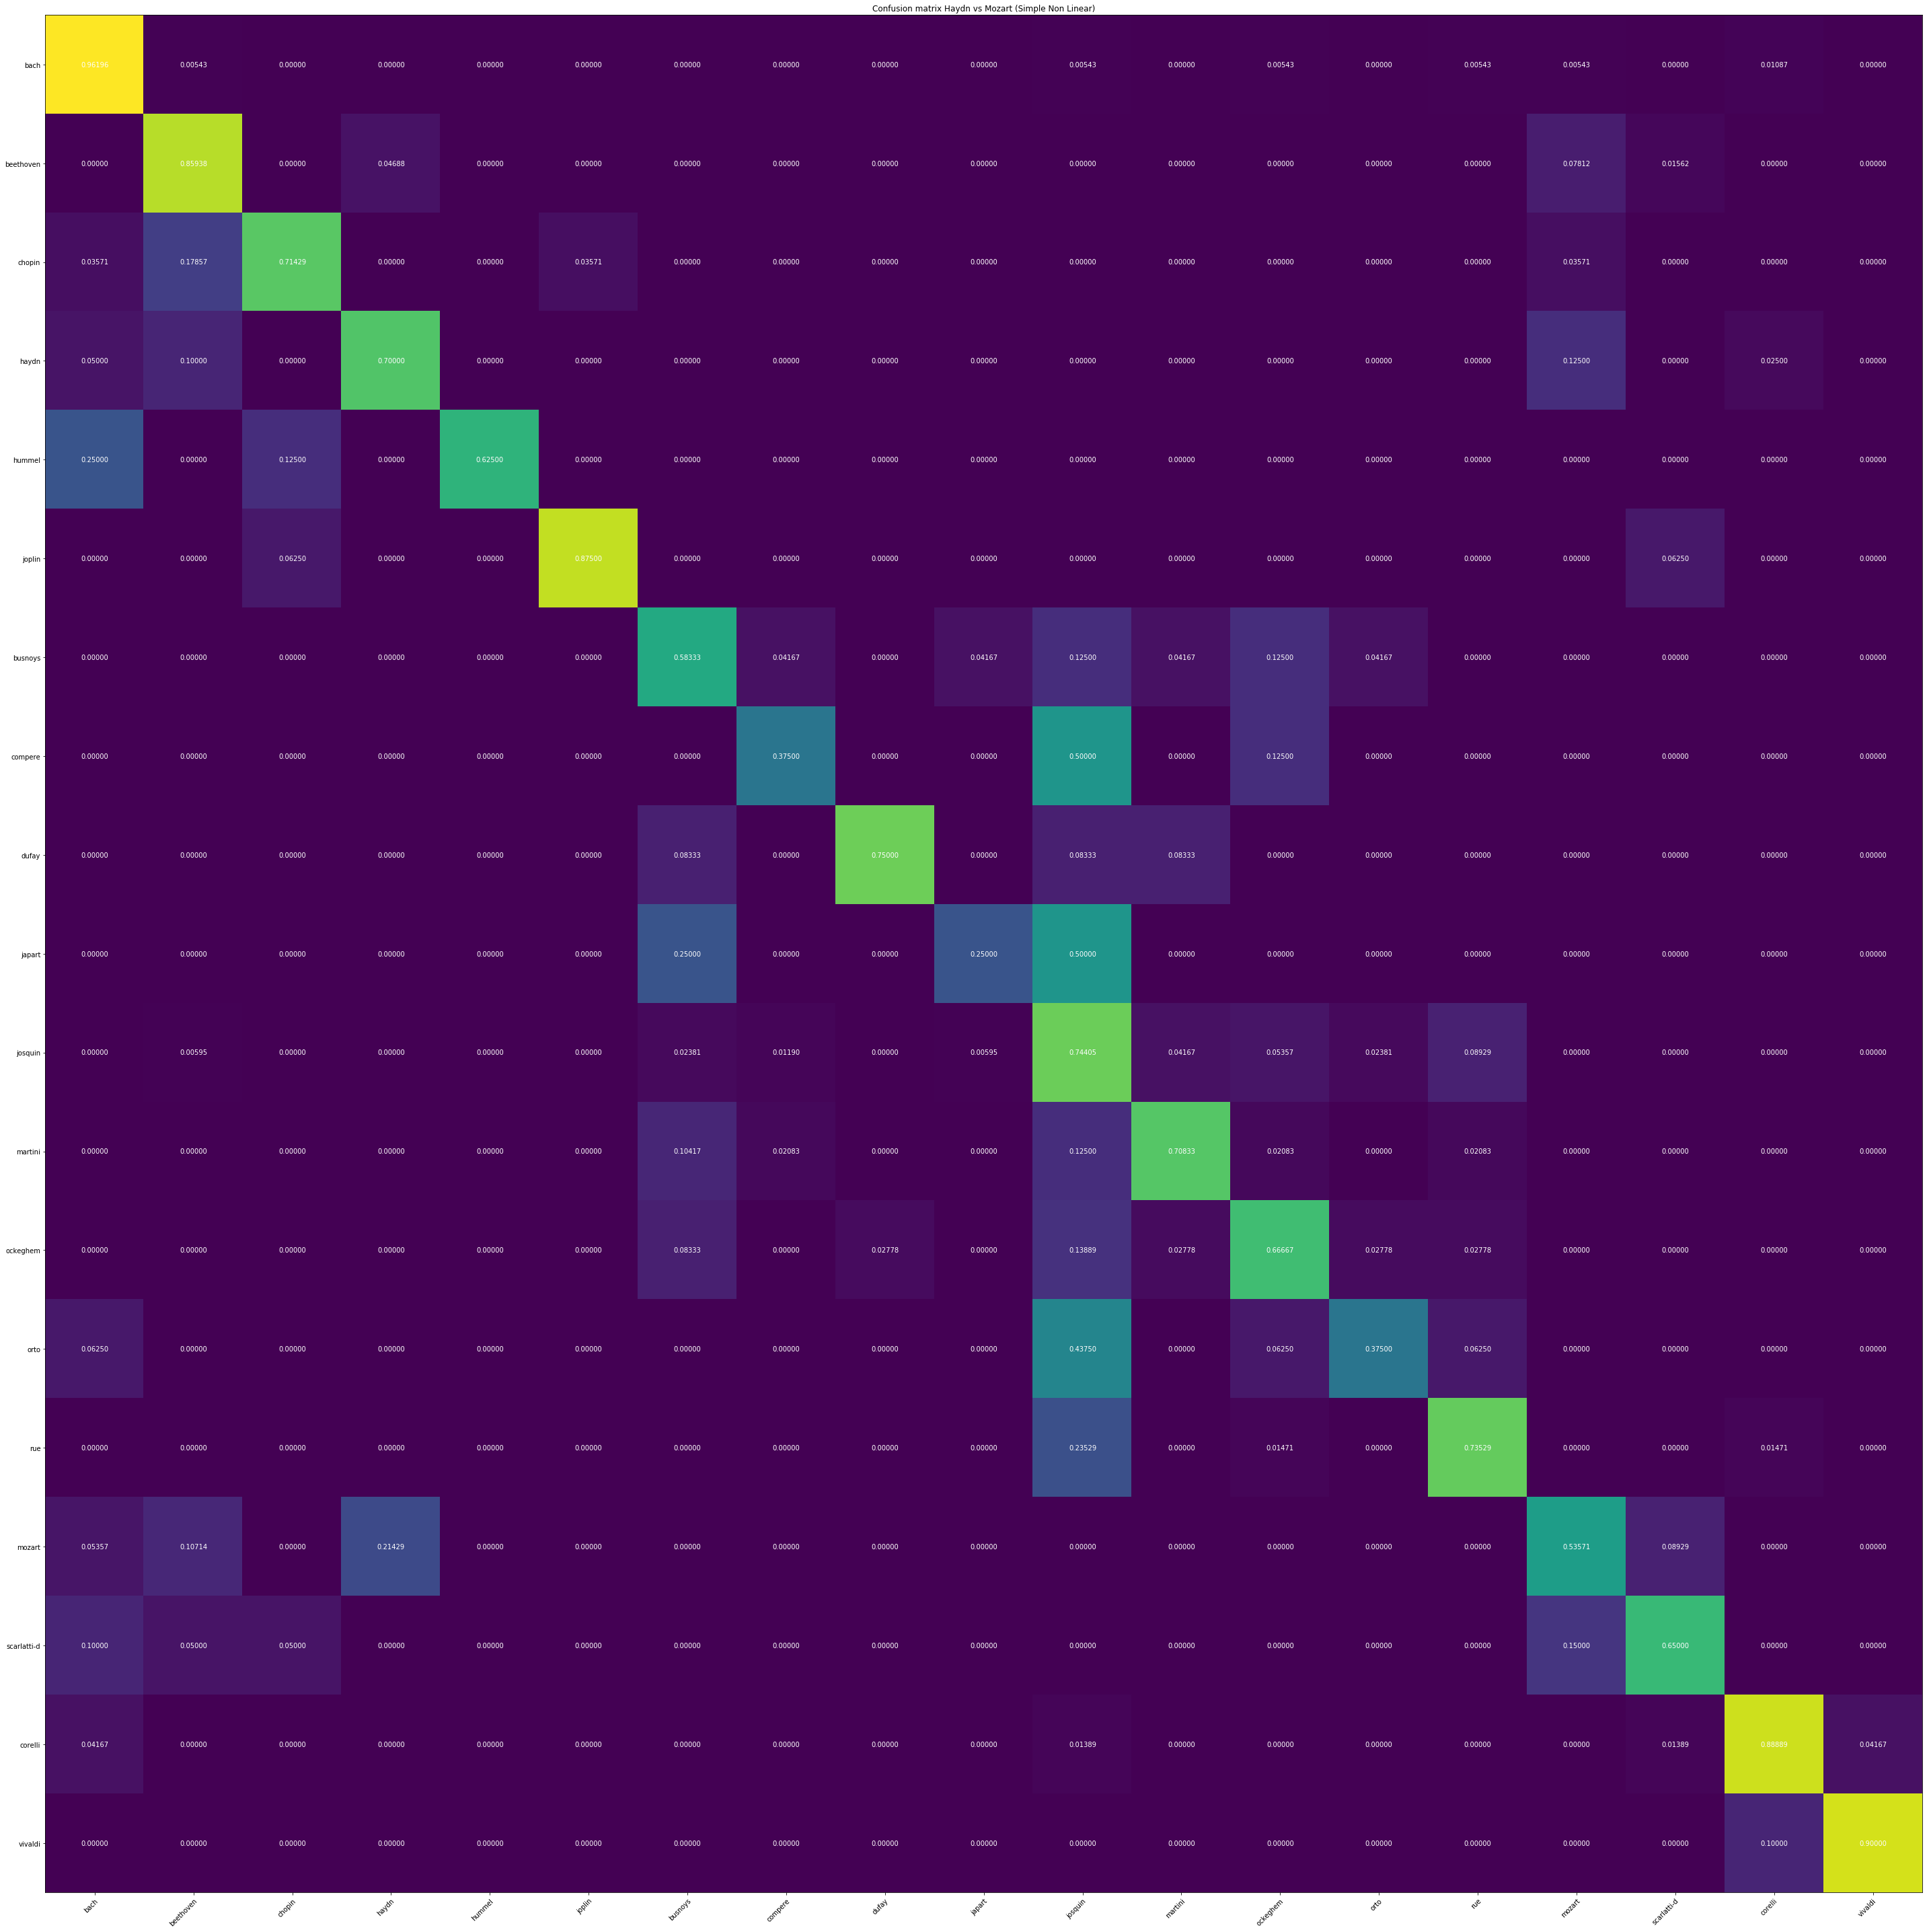

bach 45 / 46 = 0.9782608695652174
beethoven 15 / 16 = 0.9375
busnoys 5 / 6 = 0.8333333333333334
chopin 5 / 7 = 0.7142857142857143
compere 1 / 2 = 0.5
corelli 14 / 18 = 0.7777777777777778
dufay 1 / 3 = 0.3333333333333333
haydn 14 / 20 = 0.7
hummel 1 / 2 = 0.5
japart 1 / 2 = 0.5
joplin 4 / 4 = 1.0
josquin 33 / 42 = 0.7857142857142857
martini 7 / 12 = 0.5833333333333334
mozart 6 / 14 = 0.42857142857142855
ockeghem 8 / 9 = 0.8888888888888888
orto 2 / 4 = 0.5
rue 13 / 17 = 0.7647058823529411
scarlatti-d 3 / 5 = 0.6
vivaldi 9 / 10 = 0.9
187 239 0.7824267782426778
---------------------------------------------
---------------------------------------------
Fold 4
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([300, 78, 1, 3]) (70200)
wdurations torch.Size([300, 55, 1, 3]) (49500)
w2 torch.Size([300, 300, 1, 3]) (270000)
w3 torc

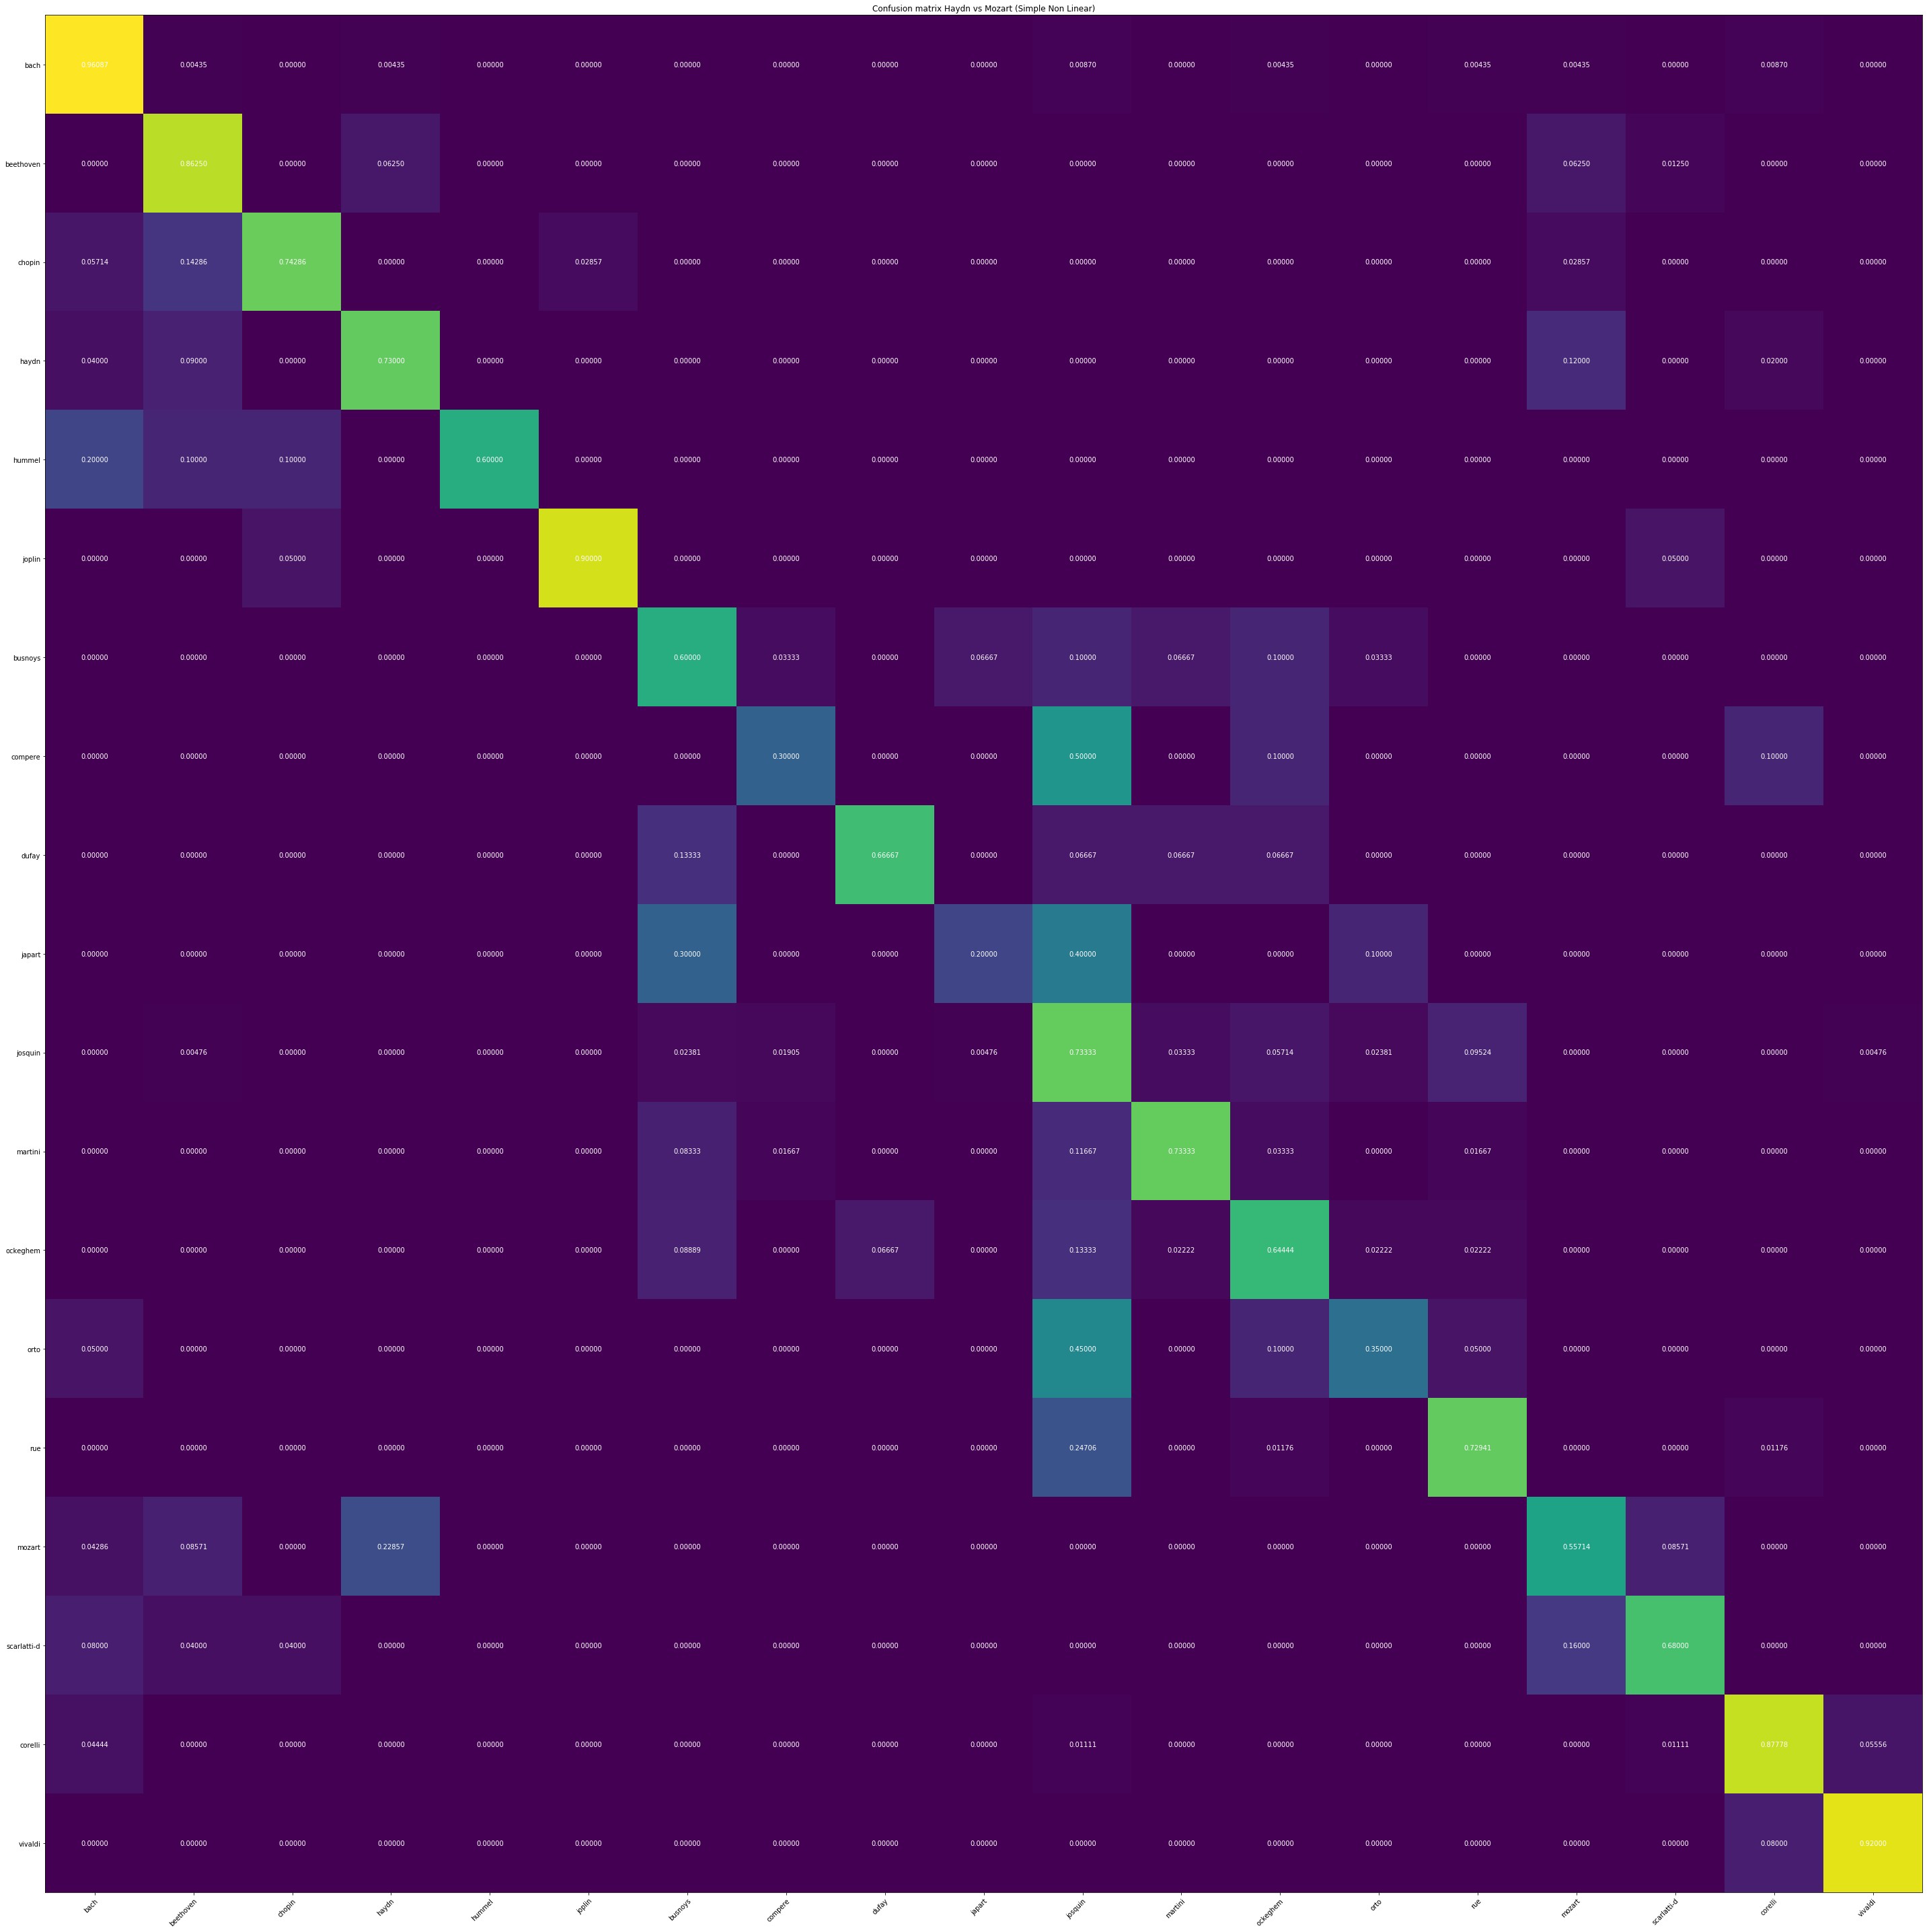

bach 44 / 46 = 0.9565217391304348
beethoven 14 / 16 = 0.875
busnoys 4 / 6 = 0.6666666666666666
chopin 6 / 7 = 0.8571428571428571
compere 0 / 2 = 0.0
corelli 15 / 18 = 0.8333333333333334
dufay 1 / 3 = 0.3333333333333333
haydn 17 / 20 = 0.85
hummel 1 / 2 = 0.5
japart 0 / 2 = 0.0
joplin 4 / 4 = 1.0
josquin 29 / 42 = 0.6904761904761905
martini 10 / 12 = 0.8333333333333334
mozart 9 / 14 = 0.6428571428571429
ockeghem 5 / 9 = 0.5555555555555556
orto 1 / 4 = 0.25
rue 12 / 17 = 0.7058823529411765
scarlatti-d 4 / 5 = 0.8
vivaldi 10 / 10 = 1.0
186 239 0.7782426778242678
---------------------------------------------
---------------------------------------------
Fold 5
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([300, 78, 1, 3]) (70200)
wdurations torch.Size([300, 55, 1, 3]) (49500)
w2 torch.Size([300, 300, 1, 3]) (270000)
w3 to

100.00  82.01   3936    0.05    1.64    14.44   4.05    
100.00  82.43   3968    0.01    1.65    14.51   3.90    
100.00  81.59   4000    0.01    1.72    14.12   3.97    
100.00  79.50   4032    0.01    1.66    14.67   4.10    
100.00  80.75   4064    0.01    1.62    14.52   4.35    
100.00  81.59   4096    0.01    1.60    14.85   3.92    
100.00  81.17   4128    0.01    1.68    14.03   3.87    
100.00  80.75   4160    0.01    1.70    14.19   4.24    
99.50   80.75   4192    0.03    1.48    14.41   4.05    
99.50   78.66   4224    0.05    1.46    14.89   3.94    
99.00   79.50   4256    0.04    1.47    14.51   4.00    
100.00  78.24   4288    0.04    1.53    14.28   4.41    
100.00  79.08   4320    0.02    1.59    14.74   4.47    
100.00  80.75   4352    0.02    1.59    14.33   4.10    
100.00  79.50   4384    0.01    1.66    14.59   3.95    
100.00  80.75   4416    0.02    1.65    14.57   4.56    
100.00  82.01   4448    0.02    1.68    14.65   3.96    
100.00  81.17   4480    0.01   

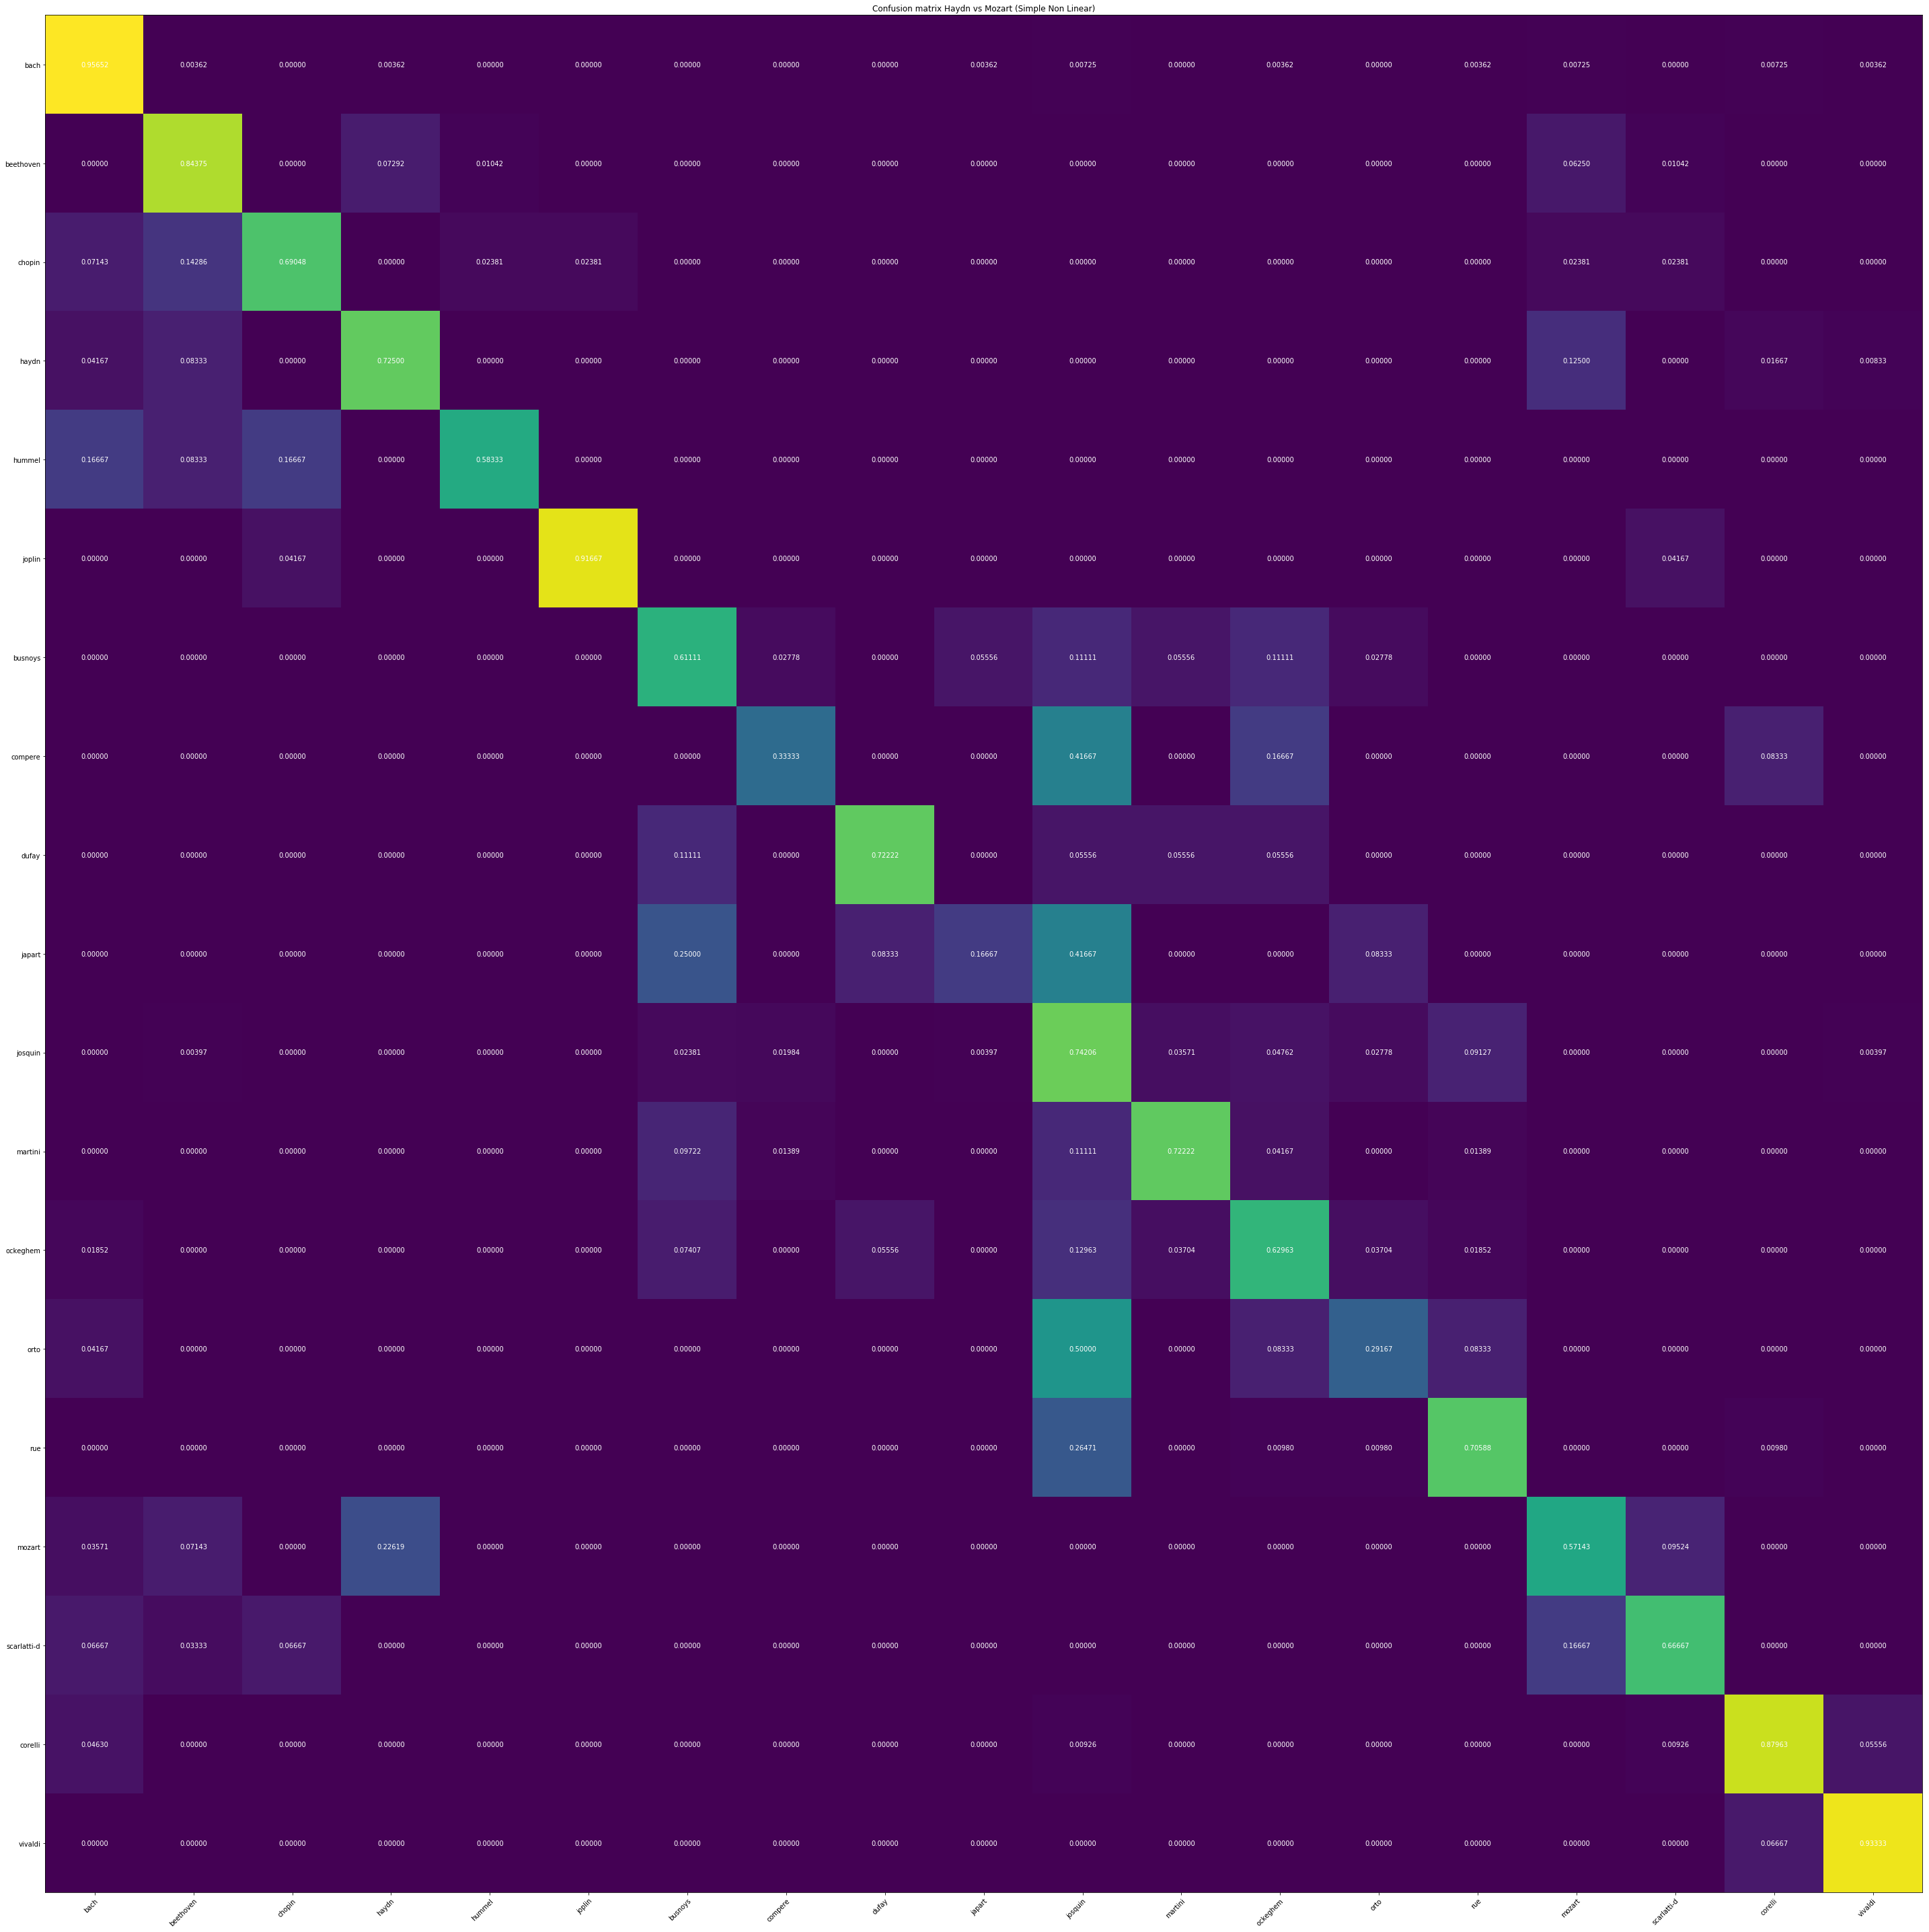

bach 43 / 46 = 0.9347826086956522
beethoven 12 / 16 = 0.75
busnoys 4 / 6 = 0.6666666666666666
chopin 3 / 7 = 0.42857142857142855
compere 1 / 2 = 0.5
corelli 16 / 18 = 0.8888888888888888
dufay 3 / 3 = 1.0
haydn 14 / 20 = 0.7
hummel 1 / 2 = 0.5
japart 0 / 2 = 0.0
joplin 4 / 4 = 1.0
josquin 33 / 42 = 0.7857142857142857
martini 8 / 12 = 0.6666666666666666
mozart 9 / 14 = 0.6428571428571429
ockeghem 5 / 9 = 0.5555555555555556
orto 0 / 4 = 0.0
rue 10 / 17 = 0.5882352941176471
scarlatti-d 3 / 5 = 0.6
vivaldi 10 / 10 = 1.0
179 239 0.7489539748953975
---------------------------------------------
---------------------------------------------
Fold 6
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([300, 78, 1, 3]) (70200)
wdurations torch.Size([300, 55, 1, 3]) (49500)
w2 torch.Size([300, 300, 1, 3]) (270000)
w3 torch.Size([300, 19]

100.00  78.66   3968    0.00    2.45    14.92   3.84    
100.00  79.08   4000    0.00    2.46    14.62   4.39    
100.00  78.66   4032    0.00    2.46    14.80   3.91    
100.00  77.82   4064    0.00    2.50    14.44   4.14    
100.00  78.66   4096    0.00    2.50    14.62   4.15    
100.00  77.82   4128    0.00    2.52    14.41   4.45    
100.00  79.08   4160    0.00    2.54    14.75   4.40    
100.00  78.66   4192    0.00    2.57    14.59   4.20    
100.00  77.41   4224    0.00    2.59    14.80   4.40    
100.00  79.08   4256    0.00    2.62    14.58   4.41    
100.00  78.24   4288    0.00    2.61    14.40   4.12    
100.00  78.24   4320    0.00    2.60    15.00   4.42    
100.00  76.99   4352    0.00    2.63    14.63   4.29    
Finished
**************
Test accuracy :  0.7824267782426778


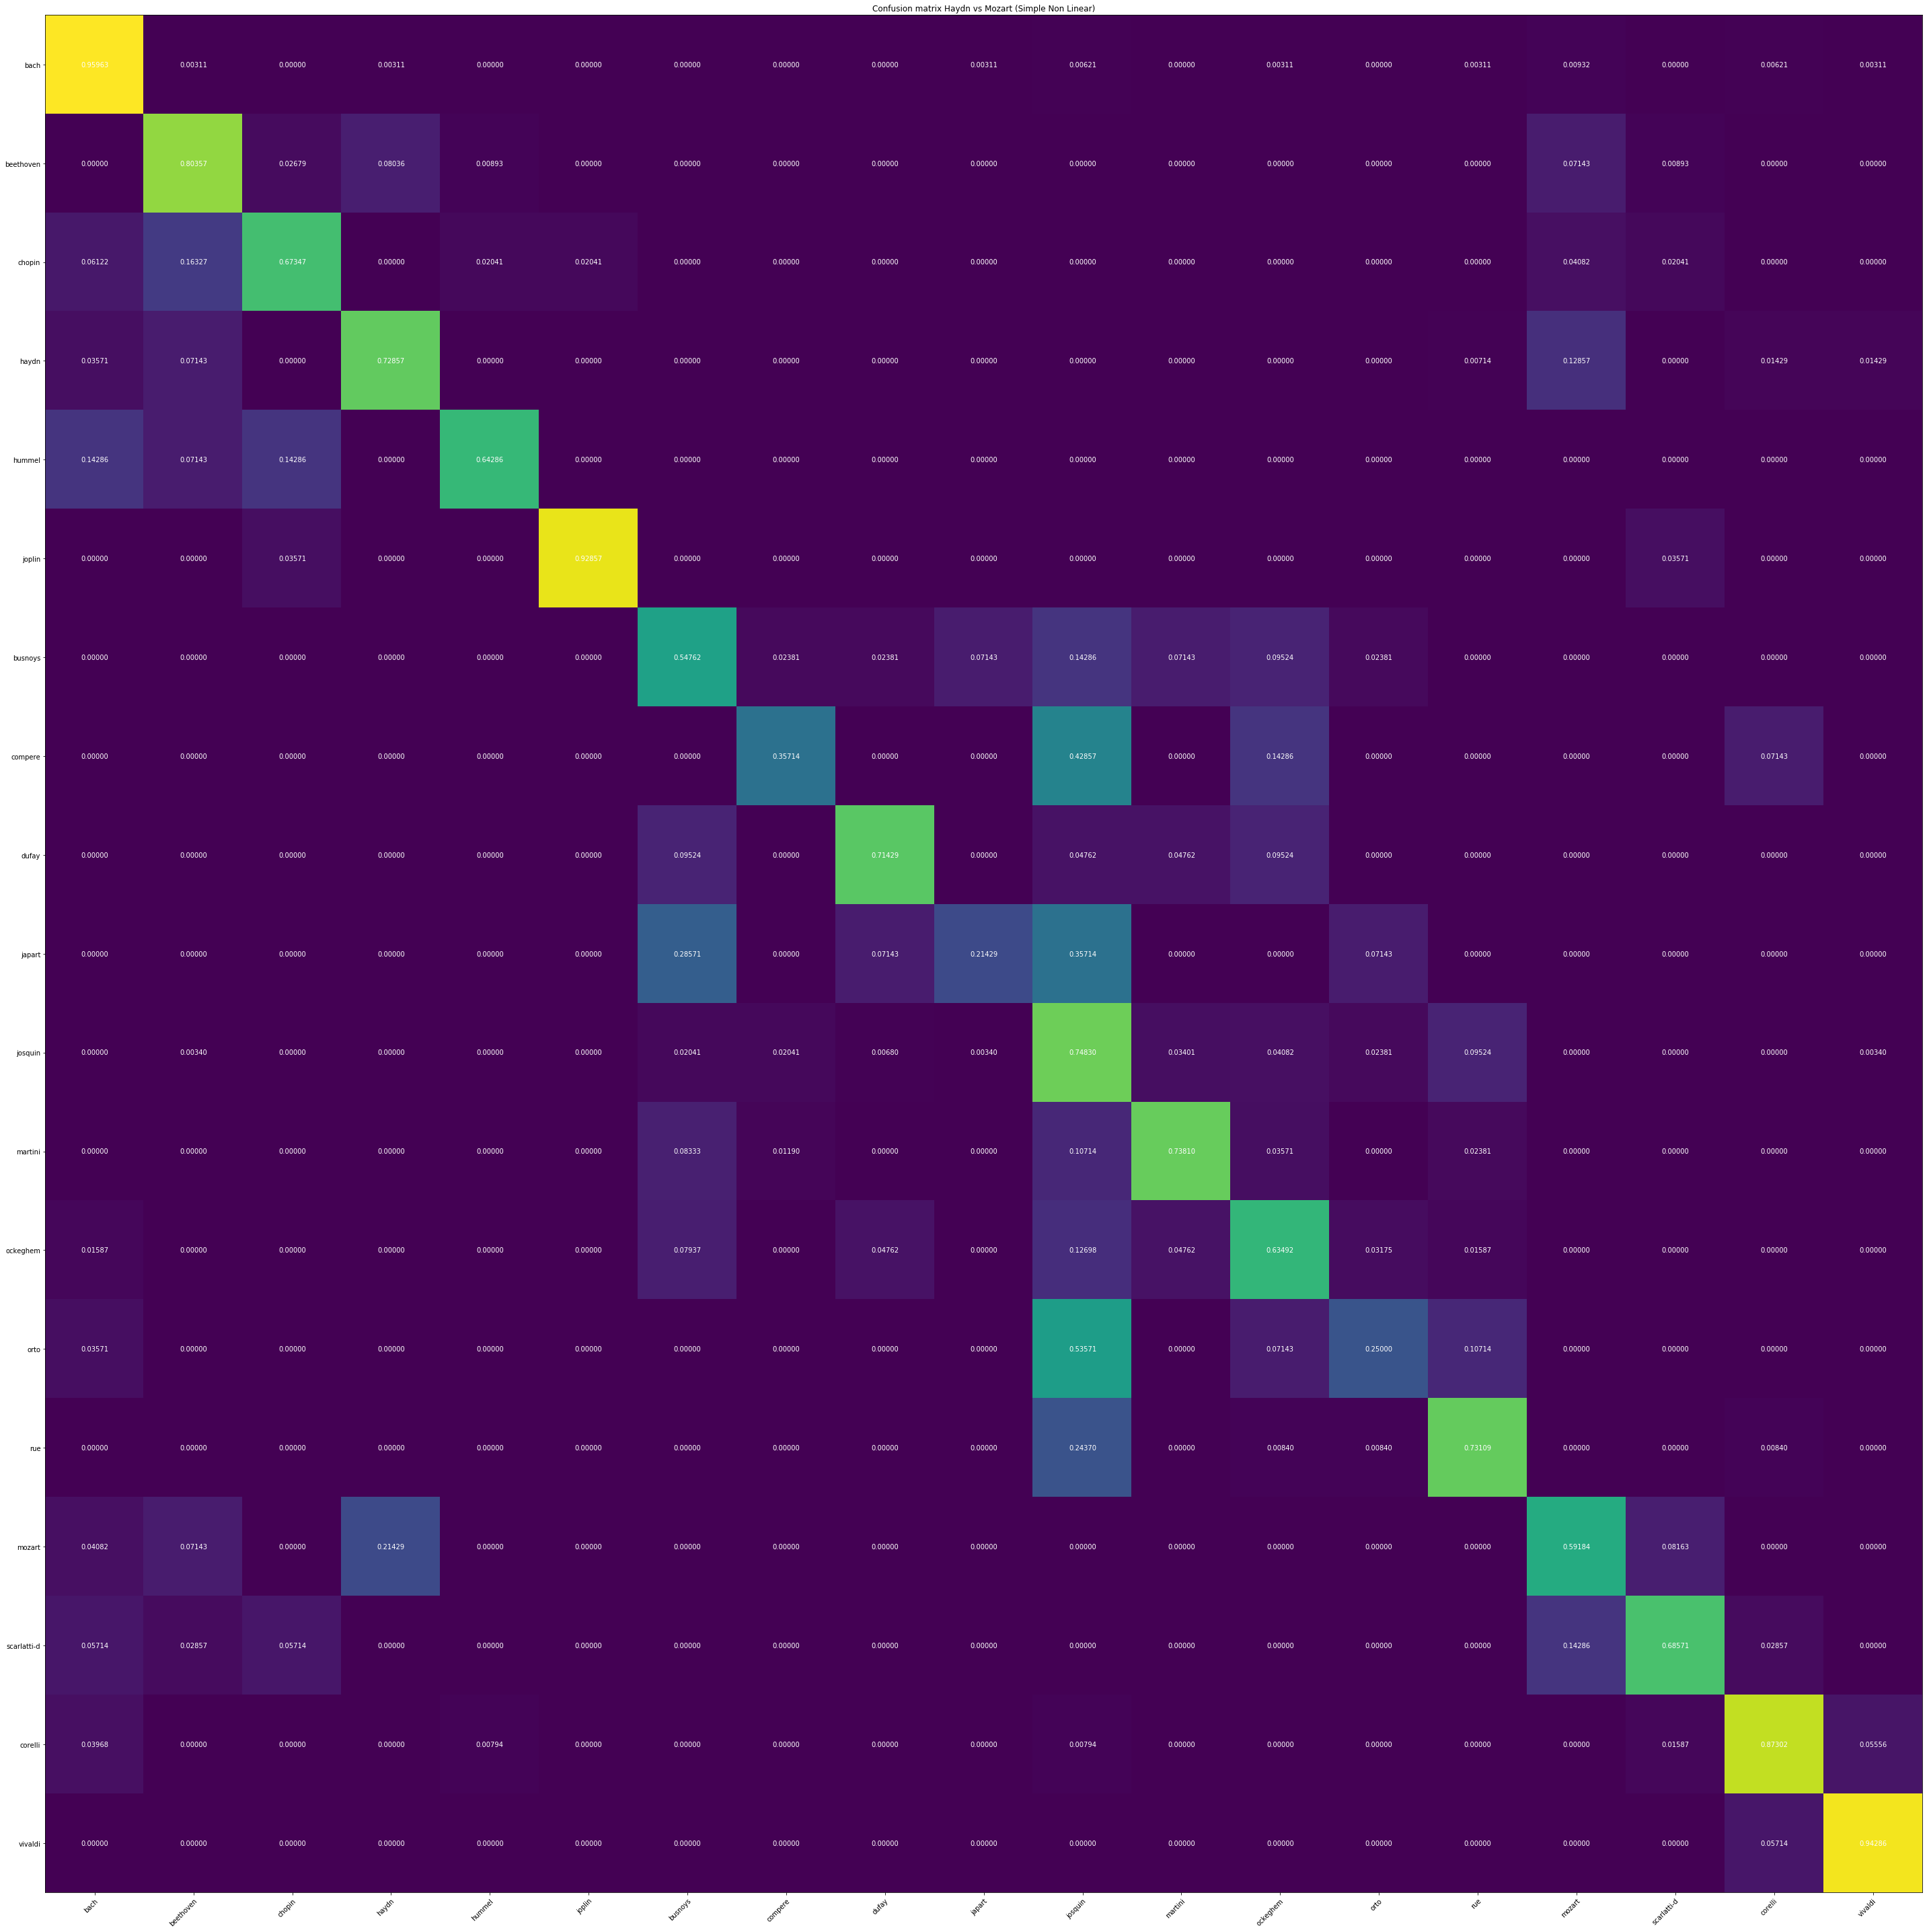

bach 45 / 46 = 0.9782608695652174
beethoven 9 / 16 = 0.5625
busnoys 1 / 6 = 0.16666666666666666
chopin 4 / 7 = 0.5714285714285714
compere 1 / 2 = 0.5
corelli 15 / 18 = 0.8333333333333334
dufay 2 / 3 = 0.6666666666666666
haydn 15 / 20 = 0.75
hummel 2 / 2 = 1.0
japart 1 / 2 = 0.5
joplin 4 / 4 = 1.0
josquin 33 / 42 = 0.7857142857142857
martini 10 / 12 = 0.8333333333333334
mozart 10 / 14 = 0.7142857142857143
ockeghem 6 / 9 = 0.6666666666666666
orto 0 / 4 = 0.0
rue 15 / 17 = 0.8823529411764706
scarlatti-d 4 / 5 = 0.8
vivaldi 10 / 10 = 1.0
187 239 0.7824267782426778
---------------------------------------------
---------------------------------------------
Fold 7
len validation_ids 246
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([300, 78, 1, 3]) (70200)
wdurations torch.Size([300, 55, 1, 3]) (49500)
w2 torch.Size([300, 300, 1, 3]) (270000)
w3 t

100.00  77.82   3936    0.01    2.21    14.18   4.16    
100.00  78.24   3968    0.01    2.25    14.83   4.42    
100.00  77.41   4000    0.01    2.27    14.54   4.20    
100.00  78.24   4032    0.01    2.31    15.15   4.16    
100.00  77.82   4064    0.01    2.34    14.33   4.23    
100.00  77.82   4096    0.01    2.37    15.06   3.96    
Finished
**************
Test accuracy :  0.7949790794979079


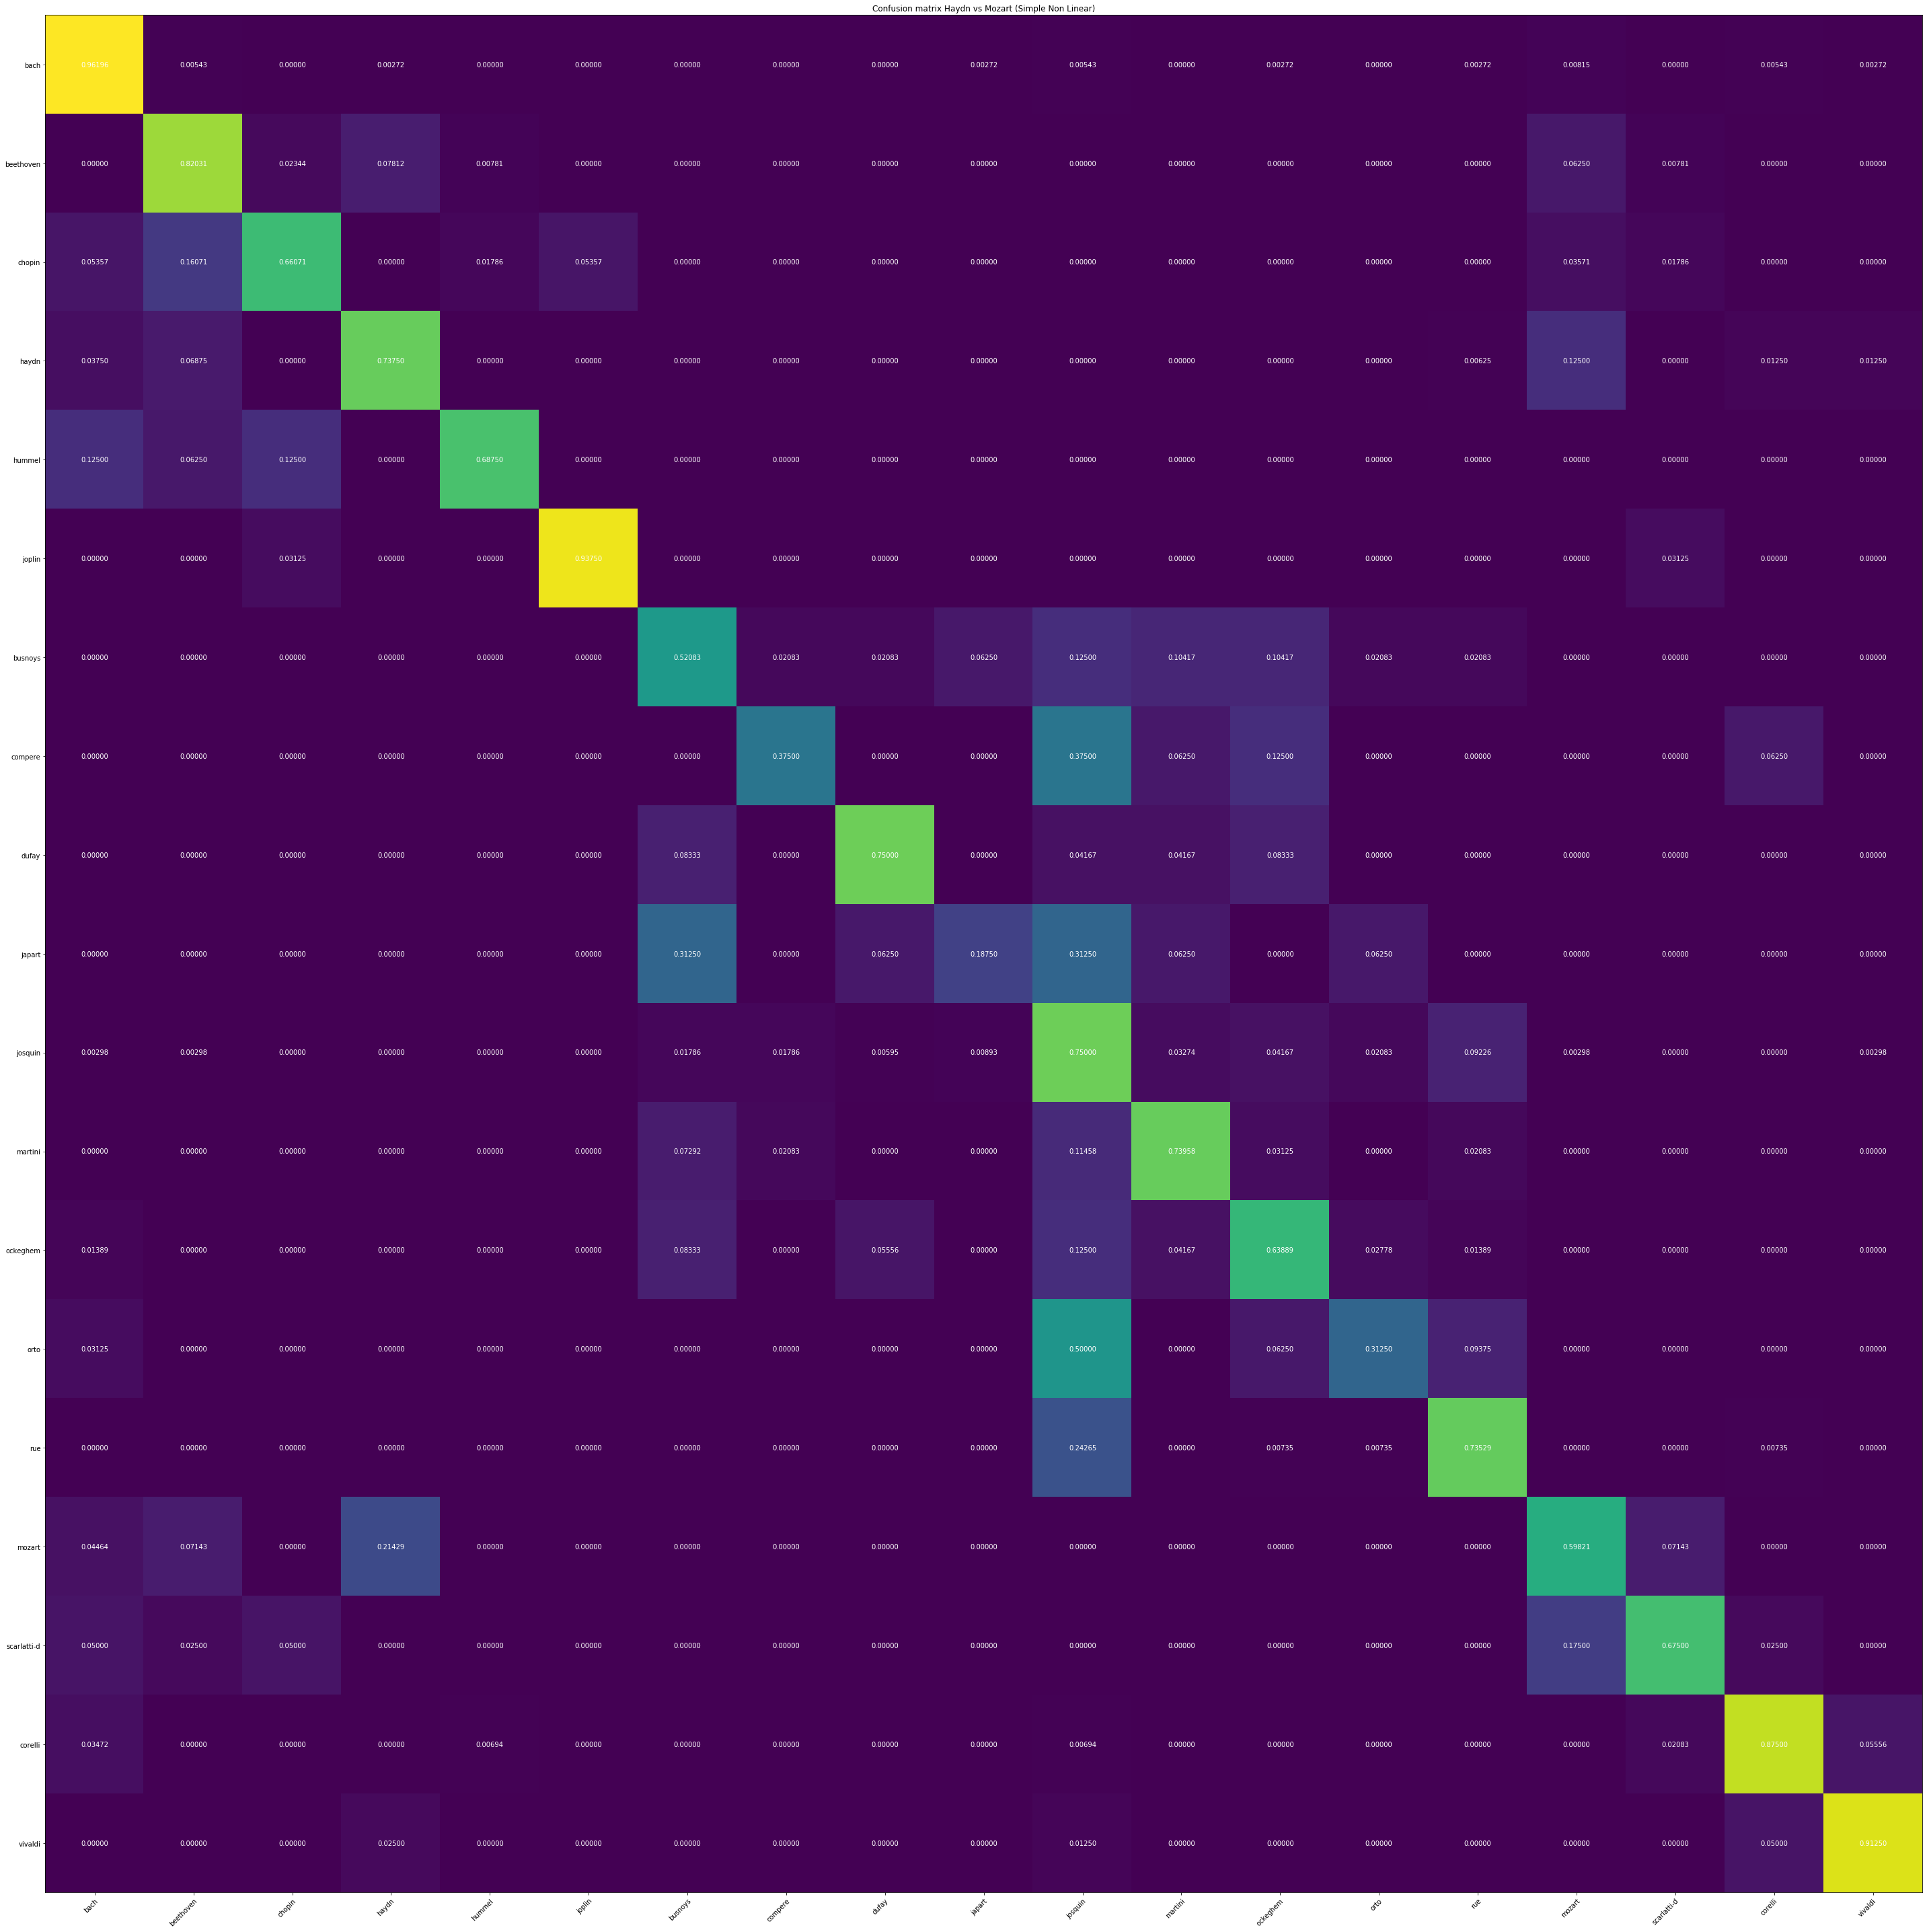

bach 45 / 46 = 0.9782608695652174
beethoven 15 / 16 = 0.9375
busnoys 2 / 6 = 0.3333333333333333
chopin 4 / 7 = 0.5714285714285714
compere 1 / 2 = 0.5
corelli 16 / 18 = 0.8888888888888888
dufay 3 / 3 = 1.0
haydn 16 / 20 = 0.8
hummel 2 / 2 = 1.0
japart 0 / 2 = 0.0
joplin 4 / 4 = 1.0
josquin 32 / 42 = 0.7619047619047619
martini 9 / 12 = 0.75
mozart 9 / 14 = 0.6428571428571429
ockeghem 6 / 9 = 0.6666666666666666
orto 3 / 4 = 0.75
rue 13 / 17 = 0.7647058823529411
scarlatti-d 3 / 5 = 0.6
vivaldi 7 / 10 = 0.7
190 239 0.7949790794979079
---------------------------------------------
---------------------------------------------
Fold 8
len validation_ids 400
len test_ids 246
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([300, 78, 1, 3]) (70200)
wdurations torch.Size([300, 55, 1, 3]) (49500)
w2 torch.Size([300, 300, 1, 3]) (270000)
w3 torch.Size([300, 19]) (5700)
bias

100.00  69.81   3720    0.00    3.19    14.36   4.75    
99.50   70.36   3750    0.01    3.05    14.46   4.64    
99.50   70.91   3780    0.02    2.89    14.87   4.41    
100.00  71.19   3810    0.01    2.93    14.07   4.67    
100.00  71.47   3840    0.01    2.88    15.44   4.82    
100.00  71.19   3870    0.00    2.79    14.75   4.89    
100.00  71.75   3900    0.00    2.87    14.38   4.89    
100.00  70.36   3930    0.00    3.02    14.39   4.60    
99.50   71.75   3960    0.02    2.99    14.21   4.69    
99.50   70.36   3990    0.09    2.94    14.36   4.70    
99.50   71.19   4020    0.02    2.91    14.86   5.00    
100.00  70.36   4050    0.01    2.95    14.48   4.49    
99.50   70.36   4080    0.02    2.60    15.52   5.14    
99.50   70.36   4110    0.02    2.51    14.60   4.91    
100.00  70.36   4140    0.01    2.61    14.11   4.65    
99.50   70.91   4170    0.01    2.64    14.56   4.68    
100.00  69.53   4200    0.00    2.78    14.88   4.93    
100.00  69.25   4230    0.01   

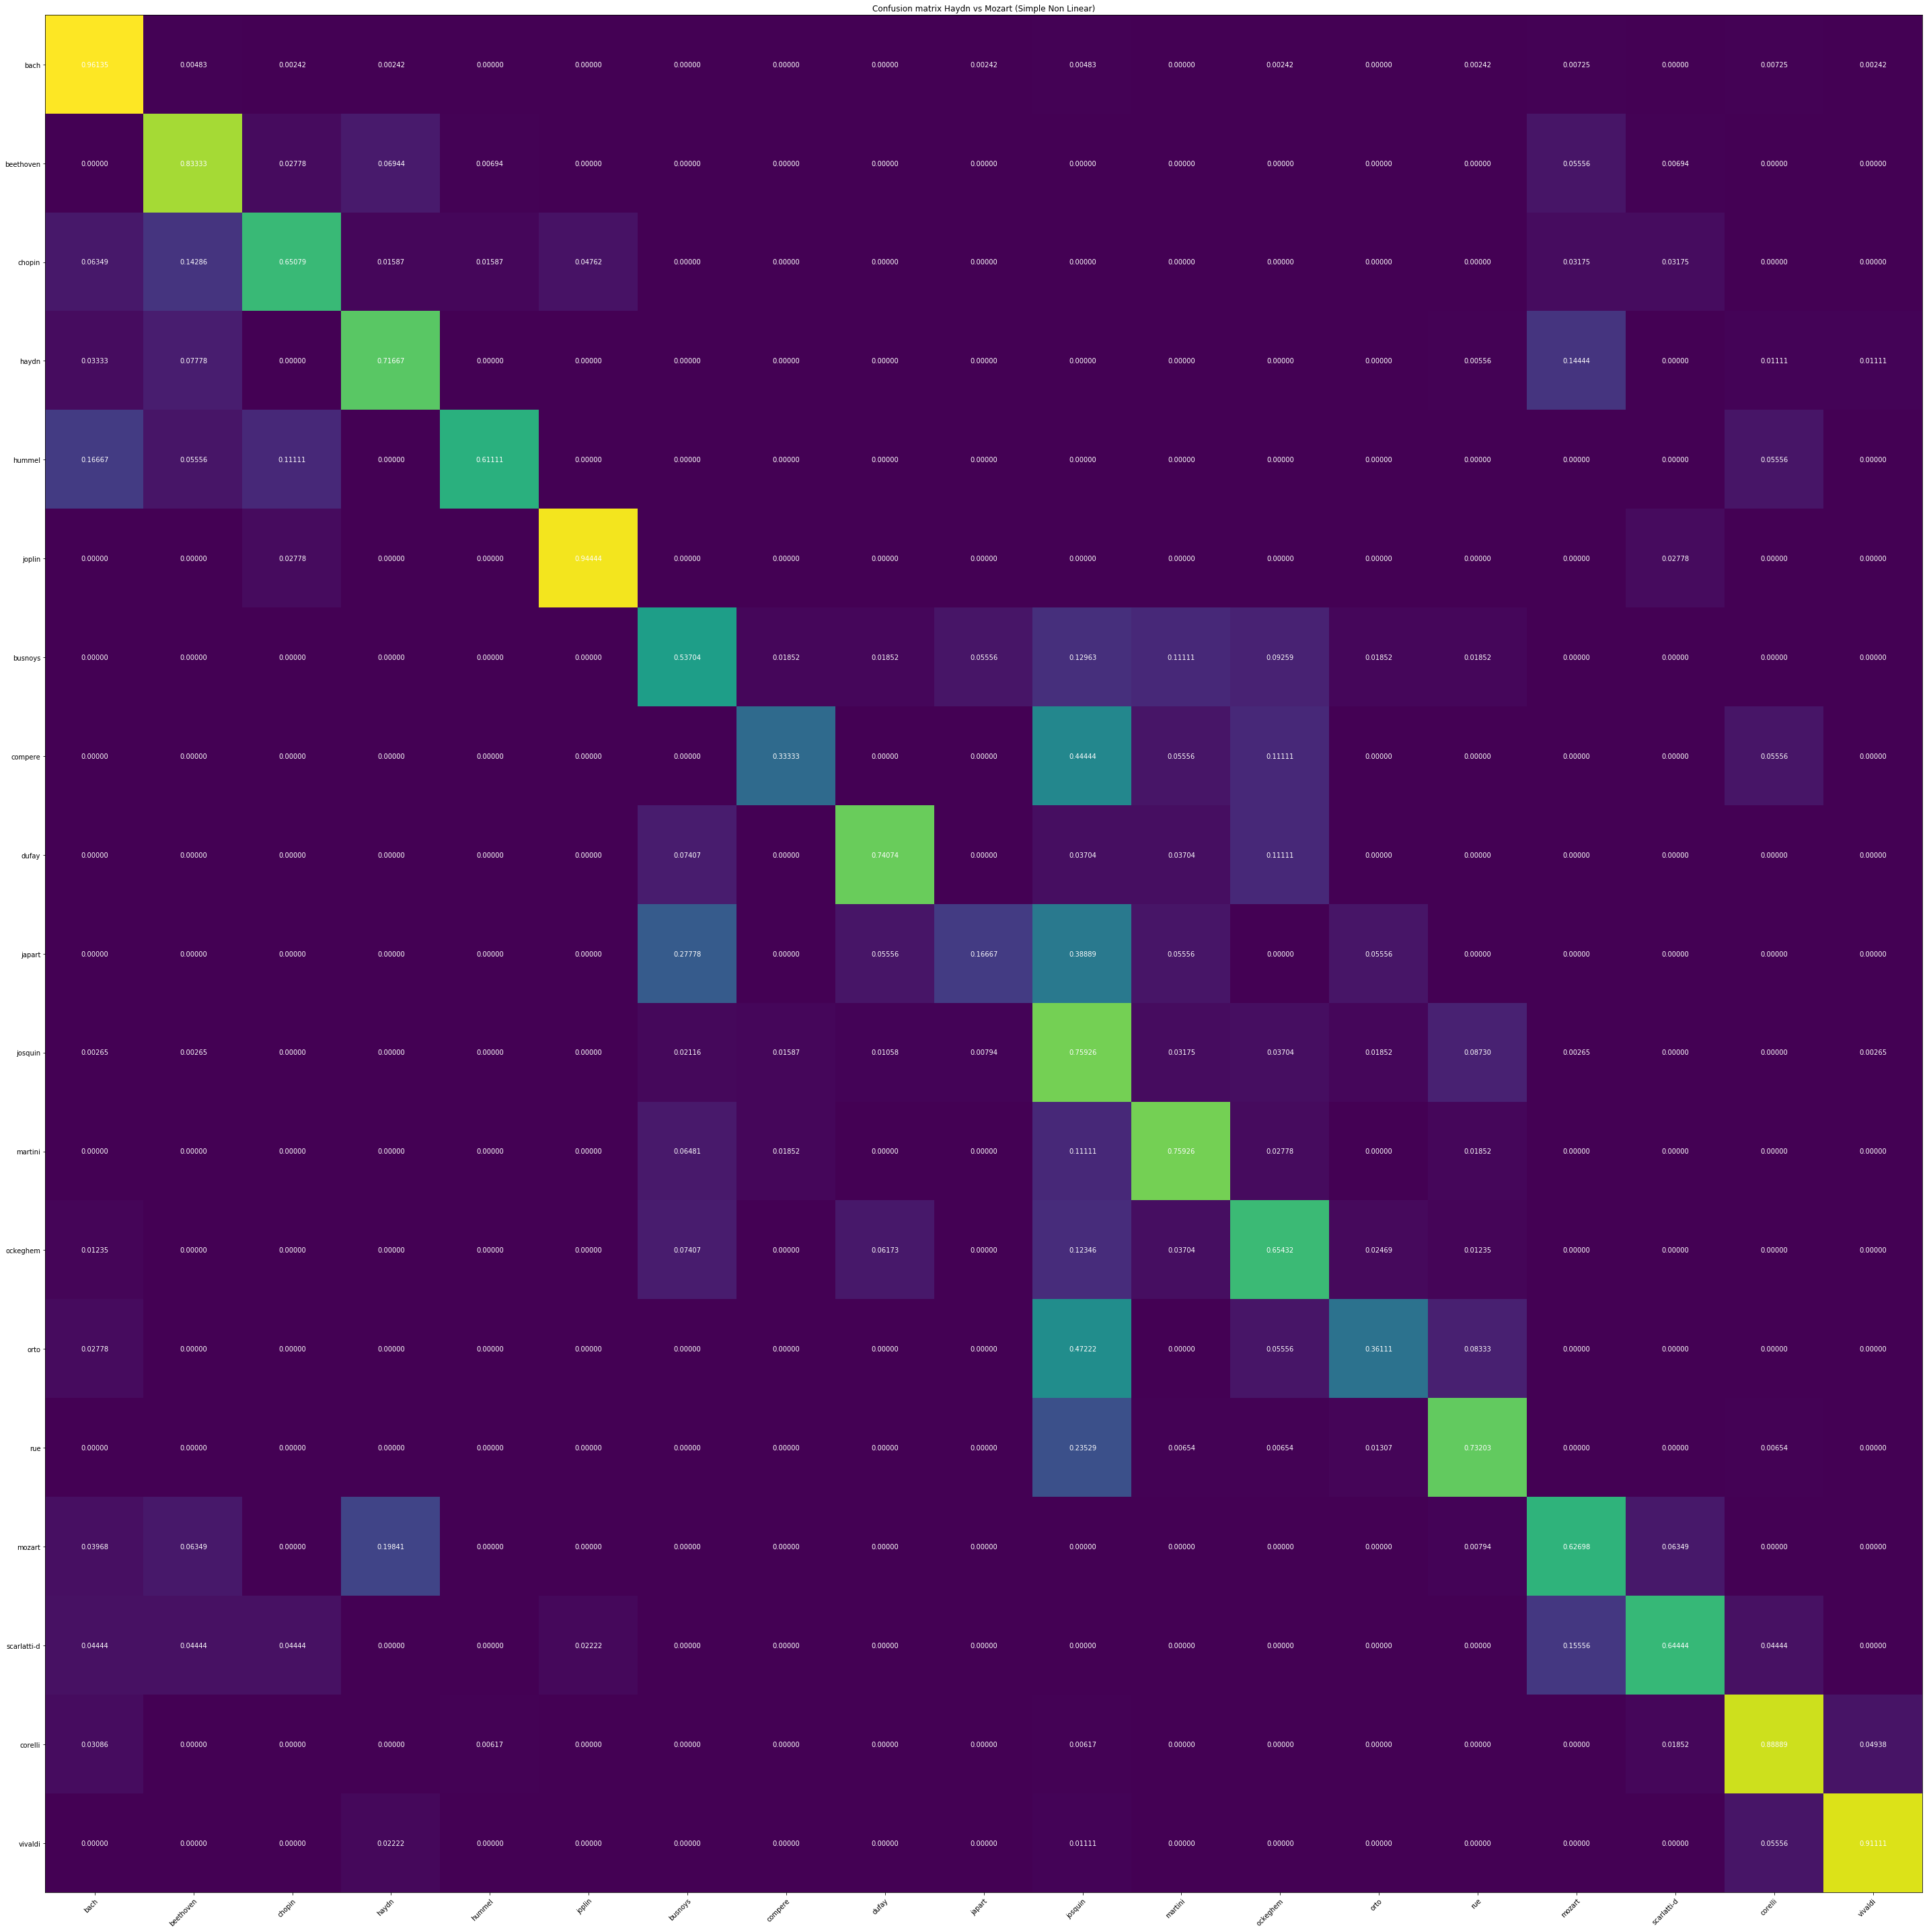

bach 44 / 46 = 0.9565217391304348
beethoven 15 / 16 = 0.9375
busnoys 4 / 6 = 0.6666666666666666
chopin 4 / 7 = 0.5714285714285714
compere 0 / 2 = 0.0
corelli 18 / 18 = 1.0
dufay 2 / 3 = 0.6666666666666666
haydn 11 / 20 = 0.55
hummel 0 / 2 = 0.0
japart 0 / 2 = 0.0
joplin 4 / 4 = 1.0
josquin 35 / 42 = 0.8333333333333334
martini 11 / 12 = 0.9166666666666666
mozart 12 / 14 = 0.8571428571428571
ockeghem 7 / 9 = 0.7777777777777778
orto 3 / 4 = 0.75
rue 12 / 17 = 0.7058823529411765
scarlatti-d 2 / 5 = 0.4
vivaldi 9 / 10 = 0.9
193 239 0.8075313807531381
---------------------------------------------
---------------------------------------------
Fold 9
len validation_ids 246
len test_ids 400
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
Found cached voices datafile at data/voices_data.npz
wnotes torch.Size([300, 78, 1, 3]) (70200)
wdurations torch.Size([300, 55, 1, 3]) (49500)
w2 torch.Size([300, 300, 1, 3]) (270000)
w3 torch.Size([300,

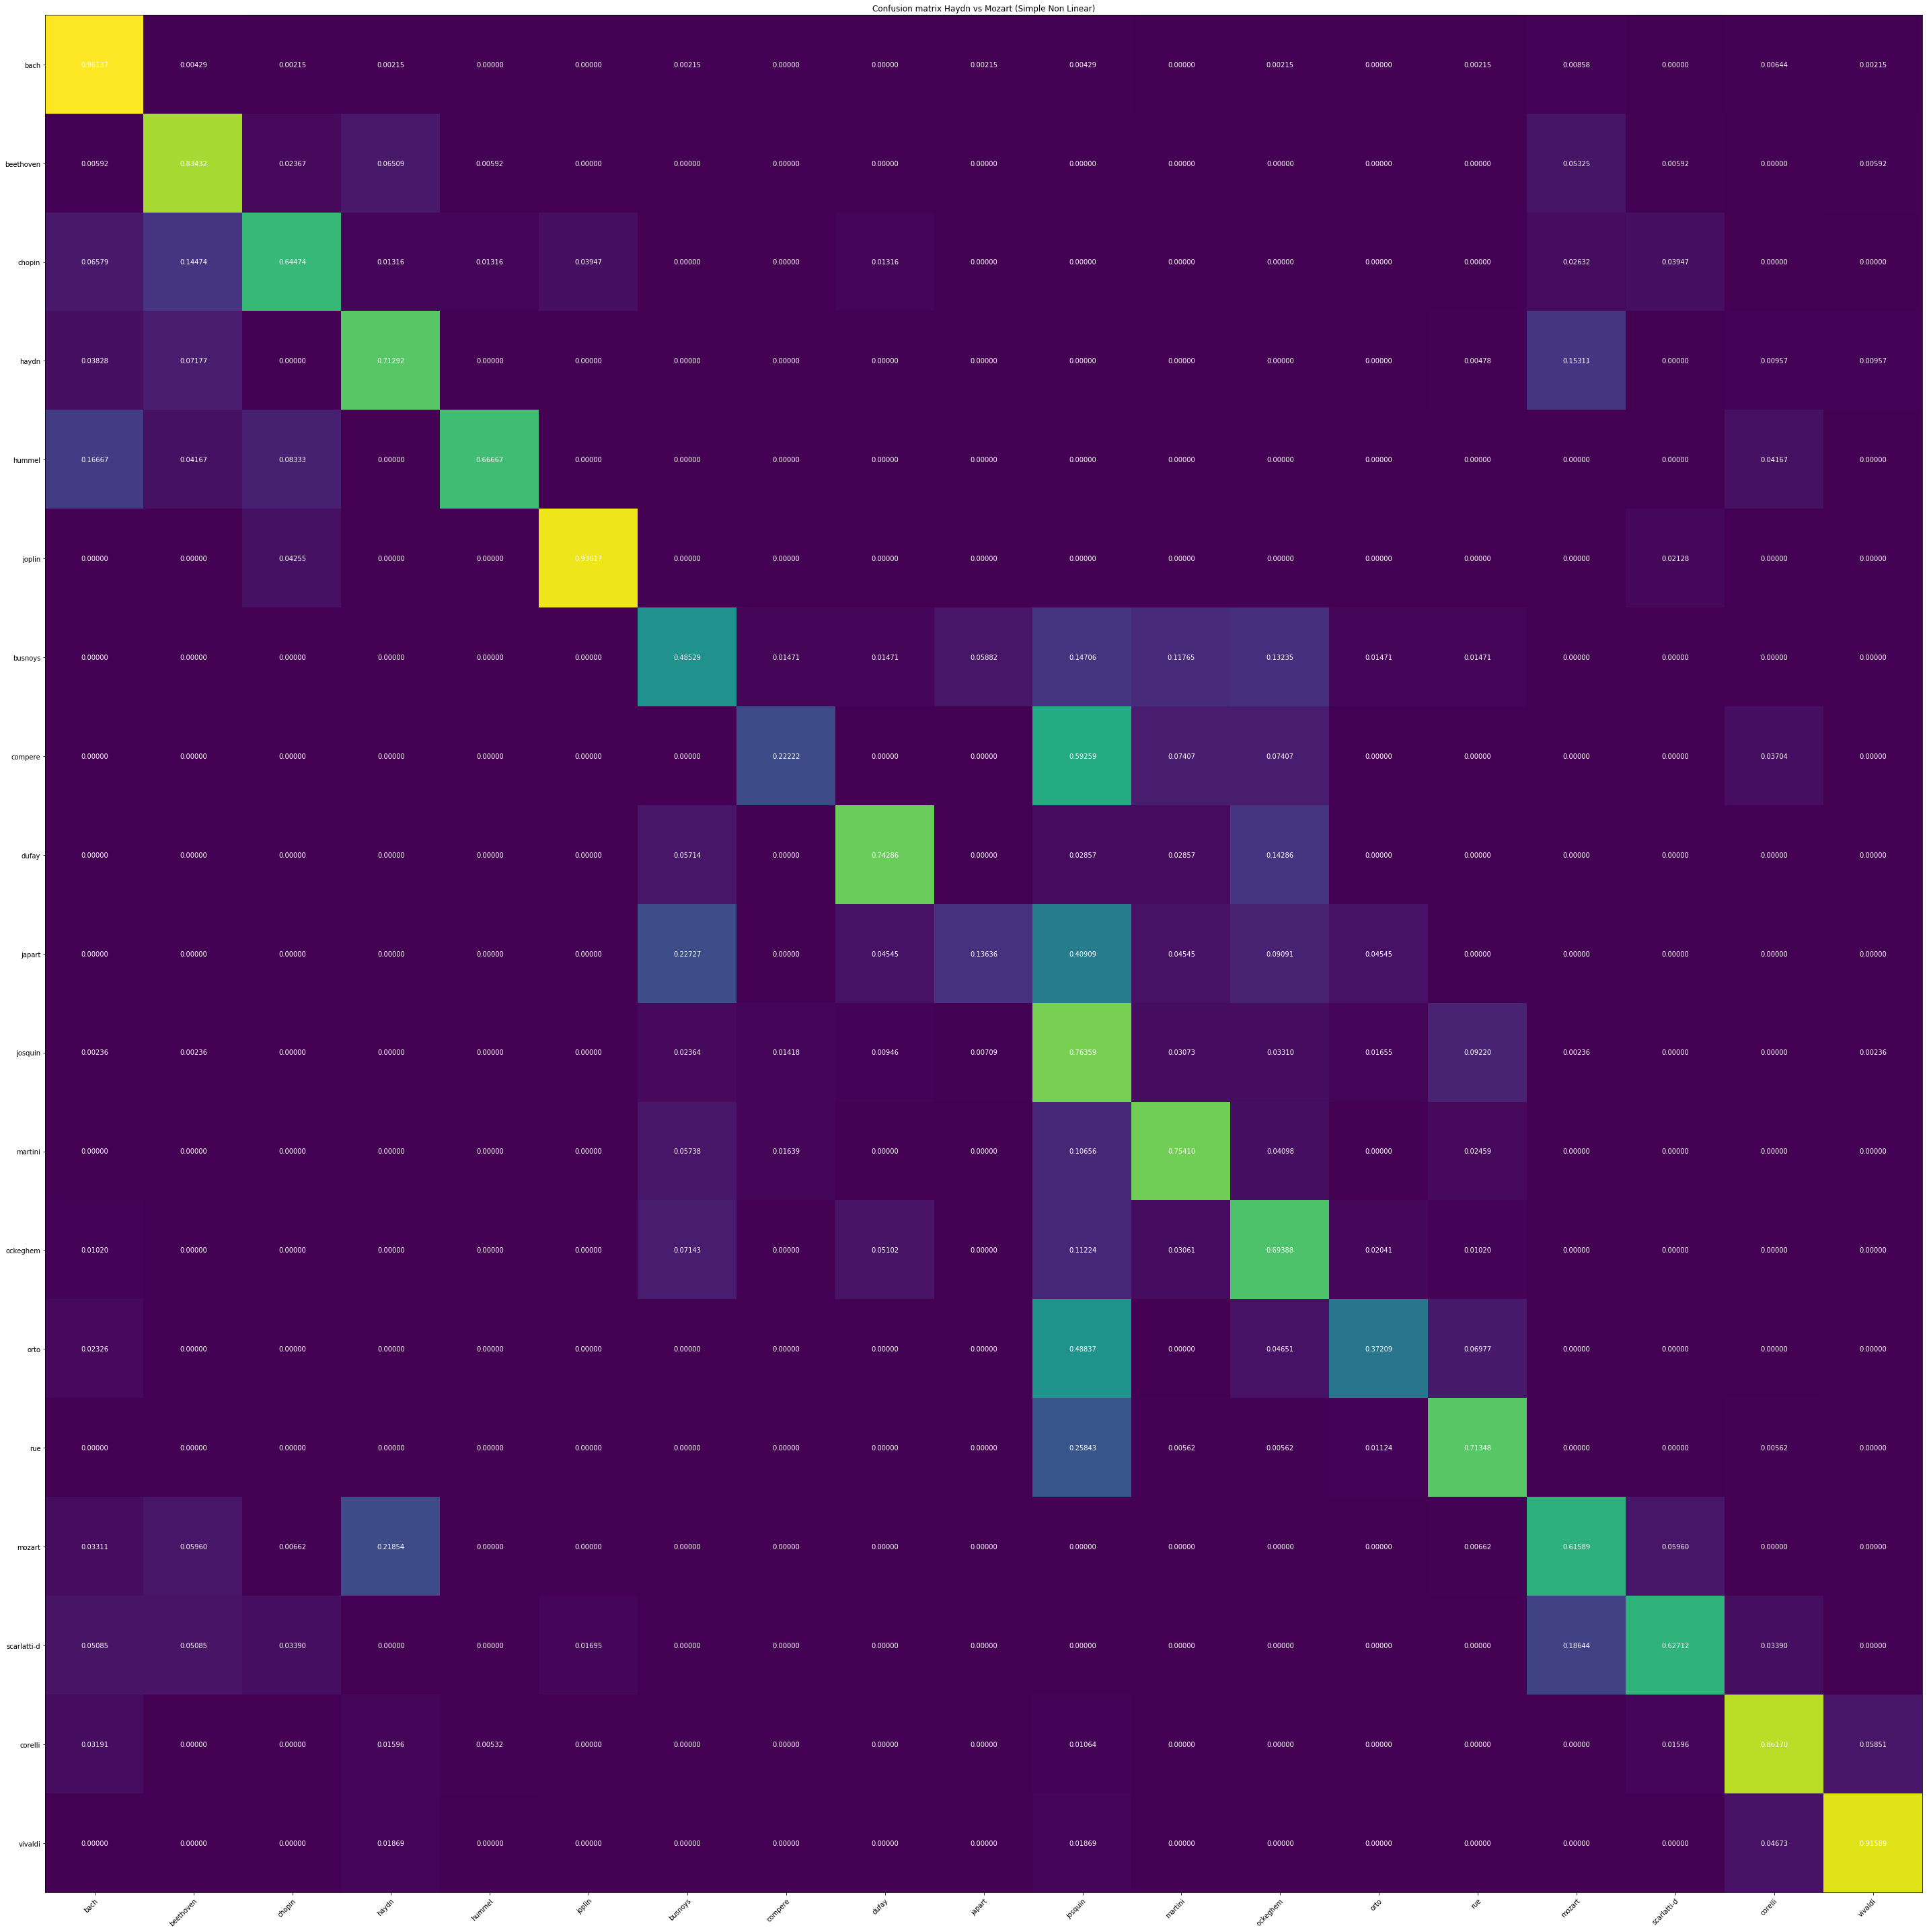

bach 50 / 52 = 0.9615384615384616
beethoven 21 / 25 = 0.84
busnoys 4 / 14 = 0.2857142857142857
chopin 8 / 13 = 0.6153846153846154
compere 0 / 9 = 0.0
corelli 18 / 26 = 0.6923076923076923
dufay 6 / 8 = 0.75
haydn 20 / 29 = 0.6896551724137931
hummel 5 / 6 = 0.8333333333333334
japart 0 / 4 = 0.0
joplin 10 / 11 = 0.9090909090909091
josquin 36 / 45 = 0.8
martini 10 / 14 = 0.7142857142857143
mozart 14 / 25 = 0.56
ockeghem 15 / 17 = 0.8823529411764706
orto 3 / 7 = 0.42857142857142855
rue 15 / 25 = 0.6
scarlatti-d 8 / 14 = 0.5714285714285714
vivaldi 16 / 17 = 0.9411764705882353
259 361 0.7174515235457064
Final real overall test accuracy: 0.7687101910828026 (1931/2512)
  bach: 0.9613733905579399 (448/466)
  beethoven: 0.834319526627219 (141/169)
  chopin: 0.6447368421052632 (49/76)
  haydn: 0.7129186602870813 (149/209)
  hummel: 0.6666666666666666 (16/24)
  joplin: 0.9361702127659575 (44/47)
  busnoys: 0.4852941176470588 (33/68)
  compere: 0.2222222222222222 (6/27)
  dufay: 0.7428571428571429 (

In [5]:
validator.run(context, checkpoint_dir=checkpoint_dir)

In [1]:
(265 + 184 + 181 + 181 + 184 + 184 + 183 + 175 + 188 + 170)/ (361 + 239 + 239 + 239 + 239 + 239 + 239 + 239 + 239 + 239)

0.7543789808917197